In this notebook GCP TPU(s) are loaded; Madrid’s previously cleaned train and test CXR jpg(s) and ehr data are loaded; then we put image, ehr data and the label in the same tf records; ehr data only model is defined; CXR only model is defined; pretrained MIMIC CXR model to identify CheXpert 14 labels is loaded; intermediated fusion model is defined; models are tuned; experiments are set up in order to find the best parameters; CXR model is retrained on full dataset using best parameters; finally results are visualized.

# Imports and Configuration

In [ ]:
# May not need them on paid tpu
!pip3 install sklearn
!pip3 install gcsfs
!pip3 install shap -q
!pip3 install seaborn
!pip3 install tableone -q
!pip3 install fsspec
!pip3 install talos
!pip3 install xlrd==1.2.0

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import os, sys, math
import json
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.2.0
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow.python.lib.io import file_io
import tensorflow.keras.backend as K
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import CustomObjectScope
import talos as ta
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import glob
import pandas as pd
import random
import gcsfs

# import cv2

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

print("Tensorflow version " + tf.__version__)
print("Numpy version " + np.__version__)
print("gcsfs version " + gcsfs.__version__)

Tensorflow version 2.4.1
Tensorflow version 2.4.1
Numpy version 1.19.5
gcsfs version 0.7.2


# Set seed

In [ ]:
# Set random seed for experiments
# works for cpu and gpu devices only but sufficient for single core tpu training
SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# This is just tuning how the data is prefetched for the dataloader
AUTO = tf.data.experimental.AUTOTUNE

# TPU Detection

In [ ]:
# Change this to true if just want to play with colab tpu resource -- which is enough to train <70 search experiments

HOSTED_RUNTIME = True

In [ ]:
# Detect hardware
try:
  if HOSTED_RUNTIME:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  else:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='cxr-test',project='hm-covid-19') # TPU selection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


In [ ]:
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [ ]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
if HOSTED_RUNTIME:
    # Run this if running on hosted runtime
    project_id = 'hm-covid-19'
    !gcloud config set project $project_id
    !echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
    !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
    !apt -qq update
    !apt -qq install gcsfuse
    !mkdir data
    !gcsfuse new_cxr_30 data

Updated property [core/project].
/usr/bin/sh: 1: cannot create /etc/apt/sources.list.d/gcsfuse.list: Permission denied
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1974  100  1974    0     0   137k      0 --:--:-- --:--:-- --:--:--  137k
E: This command can only be used by root.
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
mkdir: cannot create directory ‘data’: File exists
/usr/bin/sh: 1: gcsfuse: not found


In [ ]:
project_id='hm-covid-19'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

In [ ]:
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Define models

Data preprocessing and cleaning code has been moved to another notebook here: https://colab.research.google.com/drive/1mi_OAwLNQGSCp-iJ84A3SNY63jaDPlGa?usp=sharing


## Not tunable parameters

In [ ]:
# Not tunable input 
CLASSES = ['ALIVE','EXPIRED']

# Images
GCS_PATTERN_JPG_TRAIN = 'gs://new_cxr_30/classified/*/train_*.jpg'
GCS_PATTERN_JPG_TEST = 'gs://new_cxr_30/classified/*/test_*.jpg'
TARGET_SIZE = 320

# splitting data files between training and validation
training_filenames = tf.io.gfile.glob(GCS_PATTERN_JPG_TRAIN)
validation_filenames = tf.io.gfile.glob(GCS_PATTERN_JPG_TEST)
print(" {} training files and {} validation files".format(len(training_filenames), len(validation_filenames)))

# 2 fusion models: 1 with all features from Madrid, second with only features common across Madrid, Korean and Hoboken
# XFEATURES = ['age', 'MALE', 'vitals_temp_ed_first', 'vitals_sbp_ed_first', 'vitals_dbp_ed_first'
#             , 'vitals_hr_ed_first', 'vitals_spo2_ed_first', 'pmhx_diabetes', 'pmhx_hld', 'pmhx_htn'
#             , 'pmhx_ihd', 'pmhx_ckd', 'pmhx_copd', 'pmhx_asthma', 'pmhx_activecancer', 'pmhx_chronicliver'
#             , 'pmhx_stroke', 'pmhx_chf', 'pmhx_dementia', 'lab_glucose', 'lab_creatinine'
#             , 'lab_mean_platelet_volume', 'lab_neutrophil', 'lab_mch', 'lab_prothrombin_activity'
#             , 'lab_ldh', 'lab_rbc', 'lab_rdw', 'lab_inr', 'lab_potassium', 'lab_aptt'
#             , 'lab_lymphocyte_percentage', 'lab_platelet', 'lab_mcv', 'lab_sodium', 'lab_urea'
#             , 'lab_hct', 'lab_lymphocyte', 'lab_leukocyte', 'lab_alt', 'lab_ast', 'lab_ddimer'
#             , 'lab_neutrophil_percentage', 'lab_crp', 'lab_hemoglobin'
#             #, 'APview'
#             ]
# XFEATURES.sort()
# print(XFEATURES)
# need a mapping file that has path to image mapped to the corresponding structured data and the outcome (30 day mortality)
# hoboken_features = ['age','sex','ed_diagnosis','vitals_temp_ed_first','vitals_sbp_ed_first','vitals_dbp_ed_first','vitals_hr_ed_first','vitals_spo2_ed_first','hospital_outcome','pmhx_diabetes','pmhx_hld','pmhx_htn','pmhx_ihd','pmhx_ckd','pmhx_copd','pmhx_asthma','pmhx_activecancer','pmhx_chronicliver','pmhx_stroke','pmhx_chf','pmhx_dementia','lab_sodium','lab_leukocyte','lab_mean_platelet_volume','lab_neutrophil','lab_ddimer','lab_inr','lab_mch','lab_creatinine','lab_mcv','lab_aptt','lab_platelet','lab_lymphocyte_percentage','lab_glucose','lab_neutrophil_percentage','lab_ldh','lab_prothrombin_activity','lab_urea','lab_lymphocyte','lab_crp','lab_rdw','lab_hemoglobin','lab_rbc,','lab_hct,','lab_potassium,','lab_alt','lab_ast']
# hoboken_features.sort()
# print(hoboken_features)
# korean_features = ['age','sex','ed_diagnosis','vitals_temp_ed_first','vitals_sbp_ed_first','vitals_dbp_ed_first','vitals_hr_ed_first','vitals_spo2_ed_first','hospital_outcome','pmhx_diabetes','pmhx_hld','pmhx_htn','pmhx_ihd','pmhx_ckd','pmhx_copd','pmhx_asthma','pmhx_activecancer','pmhx_chronicliver','pmhx_stroke','pmhx_chf','pmhx_dementia','lab_sodium','lab_leukocyte','lab_mean_platelet_volume','lab_glucose','lab_hct','lab_hemoglobin','lab_creatinine','lab_lymphocyte_percentage','lab_urea','lab_inr','lab_lymphocyte','lab_ddimer','lab_crp','lab_ldh','lab_neutrophil_percentage','lab_rbc','lab_neutrophil','lab_alt','lab_potassium','lab_rdw','lab_mcv','lab_aptt','lab_mch','lab_prothrombin_activity','lab_ast','lab_platelet']
# korean_features.sort()
# print(korean_features)
# sorted

XFEATURES = ['MALE', 'age', 'lab_alt', 'lab_aptt', 'lab_ast', 'lab_creatinine', 'lab_crp', 'lab_ddimer', 'lab_glucose'
                    , 'lab_hct', 'lab_hemoglobin', 'lab_inr', 'lab_ldh', 'lab_leukocyte', 'lab_lymphocyte'
                    , 'lab_lymphocyte_percentage', 'lab_mch', 'lab_mcv', 'lab_mean_platelet_volume', 'lab_neutrophil'
                    , 'lab_neutrophil_percentage', 'lab_platelet', 'lab_potassium', 'lab_prothrombin_activity'
                    , 'lab_rbc', 'lab_rdw', 'lab_sodium', 'lab_urea', 'pmhx_activecancer', 'pmhx_asthma', 'pmhx_chf'
                    , 'pmhx_chronicliver', 'pmhx_ckd', 'pmhx_copd', 'pmhx_dementia', 'pmhx_diabetes', 'pmhx_hld'
                    , 'pmhx_htn', 'pmhx_ihd', 'pmhx_stroke', 'vitals_dbp_ed_first', 'vitals_hr_ed_first'
                    , 'vitals_sbp_ed_first', 'vitals_spo2_ed_first', 'vitals_temp_ed_first']

hoboken_features = ['sex', 
                    #'ed_diagnosis', 'hospital_outcome',
                    'age', 'lab_alt', 'lab_aptt', 'lab_ast', 'lab_creatinine', 'lab_crp', 'lab_ddimer', 'lab_glucose'
                    , 'lab_hct,', 'lab_hemoglobin', 'lab_inr', 'lab_ldh', 'lab_leukocyte', 'lab_lymphocyte'
                    , 'lab_lymphocyte_percentage', 'lab_mch', 'lab_mcv', 'lab_mean_platelet_volume', 'lab_neutrophil'
                    , 'lab_neutrophil_percentage', 'lab_platelet', 'lab_potassium,', 'lab_prothrombin_activity'
                    , 'lab_rbc,', 'lab_rdw', 'lab_sodium', 'lab_urea', 'pmhx_activecancer', 'pmhx_asthma', 'pmhx_chf'
                    , 'pmhx_chronicliver', 'pmhx_ckd', 'pmhx_copd', 'pmhx_dementia', 'pmhx_diabetes', 'pmhx_hld'
                    , 'pmhx_htn', 'pmhx_ihd', 'pmhx_stroke', 'vitals_dbp_ed_first', 'vitals_hr_ed_first'
                    , 'vitals_sbp_ed_first', 'vitals_spo2_ed_first', 'vitals_temp_ed_first']
korean_features = ['sex', 
                   #'ed_diagnosis', 'hospital_outcome',
                   'age', 'lab_alt', 'lab_aptt', 'lab_ast', 'lab_creatinine', 'lab_crp', 'lab_ddimer', 'lab_glucose'
                   , 'lab_hct', 'lab_hemoglobin', 'lab_inr', 'lab_ldh', 'lab_leukocyte', 'lab_lymphocyte'
                   , 'lab_lymphocyte_percentage', 'lab_mch', 'lab_mcv', 'lab_mean_platelet_volume', 'lab_neutrophil'
                   , 'lab_neutrophil_percentage', 'lab_platelet', 'lab_potassium', 'lab_prothrombin_activity'
                   , 'lab_rbc', 'lab_rdw', 'lab_sodium', 'lab_urea', 'pmhx_activecancer', 'pmhx_asthma', 'pmhx_chf'
                   , 'pmhx_chronicliver', 'pmhx_ckd', 'pmhx_copd', 'pmhx_dementia', 'pmhx_diabetes', 'pmhx_hld'
                   , 'pmhx_htn', 'pmhx_ihd', 'pmhx_stroke', 'vitals_dbp_ed_first', 'vitals_hr_ed_first'
                   , 'vitals_sbp_ed_first', 'vitals_spo2_ed_first', 'vitals_temp_ed_first']

# number of features seem the same but it seems there are more missing values in hoboken and korean datasets
print(len(XFEATURES))
print(len(hoboken_features))
print(len(korean_features))

 1393 training files and 457 validation files
45
45
45


In [ ]:
# these data have previously been cleaned and normalized
madrid = pd.read_csv('gs://new_cxr_30/split/valtest_structured.csv')
print(madrid.shape)
print(madrid[madrid.expired_30_days==1].shape)
madrid.head()

(457, 52)
(43, 52)


,Unnamed: 0,SOPInstanceUID,path,expired_30_days,patient_id,age,MALE,vitals_temp_ed_first,vitals_sbp_ed_first,vitals_dbp_ed_first,...,lab_lymphocyte,lab_leukocyte,lab_alt,lab_ast,lab_ddimer,lab_neutrophil_percentage,lab_crp,lab_hemoglobin,APview,bbox_coordinates
0,0,1.2.124.113532.1498221512208150662116715066119...,gs://new_cxr_30/classified/ALIVE/test_1.2.124....,0,661.0,-0.250000,0.0,0.000000,-2.133333,-3.875,...,-0.735849,1.462661,0.000000,0.000000,0.000000,1.293233,0.195206,-0.941176,1,"[135, 29, 167, 123, 24, 31, 264, 231]"
1,1,1.2.124.113532.1611534457135871191862002058421...,gs://new_cxr_30/classified/ALIVE/test_1.2.124....,0,1434.0,-0.125000,1.0,2.500000,1.666667,1.250,...,-1.018868,2.039485,-0.052117,-0.388610,-0.654905,1.503759,3.098790,0.529412,1,"[130, 0, 198, 138, 4, 17, 318, 241]"
2,2,1.2.840.113619.2.202.4.2147483647.1585562476.4...,gs://new_cxr_30/classified/ALIVE/test_1.2.840....,0,1407.0,0.333333,1.0,0.000000,0.000000,0.000,...,-1.075472,-0.916738,0.247557,0.616415,11.133380,-0.067669,0.721019,-0.941176,1,"[141, 0, 178, 111, 32, 17, 307, 211]"
3,3,1.2.840.113619.2.202.4.2147483647.1585896668.8...,gs://new_cxr_30/classified/ALIVE/test_1.2.840....,0,1609.0,0.291667,0.0,-0.333333,0.533333,0.250,...,0.528302,0.243777,-0.579805,-0.871022,0.985180,0.015038,-0.501428,-1.176471,1,"[138, 0, 175, 149, 38, 61, 302, 259]"
4,4,1.2.840.113619.2.202.4.2147483647.1586241488.7...,gs://new_cxr_30/classified/ALIVE/test_1.2.840....,0,216.0,-0.541667,0.0,-0.333333,-0.200000,-0.625,...,-0.283019,-0.545923,-0.827362,-0.321608,-0.564573,-0.751880,-0.720121,0.352941,1,"[129, 0, 187, 144, 31, 25, 288, 249]"


In [ ]:
# still would need same preprocessing steps as the Madrid data (from Wesley's notebook) - NaN values, no MALE feature encoding
# use scaler from madrid train data to fit/normalize hoboken and korean test data
# need to add image "path" info to same file
# need to add "expired_30_days" outcome column to same file

# hoboken structured data
#hobo = pd.read_excel('gs://hoboken_structured_data/hoboken_structured_data.xlsx')
#hobo.head()

## Data loaders

In [ ]:
structured_path = 'gs://new_cxr_30/split/valtest_structured.csv'
dfstructure = pd.read_csv(structured_path)
# dfstructure.head()
print(dfstructure.shape)
is_NaN = dfstructure.isnull()
row_has_NaN = is_NaN.any(axis=1)
# dfstructure = dfstructure[~row_has_NaN].copy()
# print(dfstructure.shape)
dfstructure[row_has_NaN].head()


(457, 52)


,Unnamed: 0,SOPInstanceUID,path,expired_30_days,patient_id,age,MALE,vitals_temp_ed_first,vitals_sbp_ed_first,vitals_dbp_ed_first,...,lab_lymphocyte,lab_leukocyte,lab_alt,lab_ast,lab_ddimer,lab_neutrophil_percentage,lab_crp,lab_hemoglobin,APview,bbox_coordinates
66,66,1.3.12.2.1107.5.3.56.3575.11.202003231216470983,gs://new_cxr_30/classified/ALIVE/test_1.3.12.2...,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"[139, 29, 194, 184, 55, 70, 292, 286]"
67,67,1.3.12.2.1107.5.3.56.3575.11.202003231219100126,gs://new_cxr_30/classified/ALIVE/test_1.3.12.2...,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"[137, 29, 158, 144, 41, 73, 287, 224]"
68,68,1.3.12.2.1107.5.3.56.3575.11.202003231827560130,gs://new_cxr_30/classified/ALIVE/test_1.3.12.2...,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"[125, 29, 174, 166, 28, 44, 284, 256]"
69,69,1.3.12.2.1107.5.3.56.3575.11.202003241049480745,gs://new_cxr_30/classified/ALIVE/test_1.3.12.2...,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"[138, 18, 174, 139, 25, 47, 291, 230]"
70,70,1.3.12.2.1107.5.3.56.3575.11.202003241703070834,gs://new_cxr_30/classified/ALIVE/test_1.3.12.2...,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"[142, 29, 178, 148, 51, 57, 284, 233]"


In [ ]:
# now just have to put image, structured data and the label in the same tf records
# Adapted from: https://androidkt.com/feed-tfrecord-to-keras/
def get_augmented_paths(df,subdirname):
    df = df.copy()
    df['path'] = [x.replace('classified',subdirname) for x in df['path']]
    return df

def prepare_structured_data(dfstructure, model_type, xfeatures, rseed, augment_bbox=False, train = True):
    if model_type in ['tab_model','fused_model']:
        # these are images with no structured data
        is_NaN = dfstructure.isnull() 
        row_has_NaN = is_NaN.any(axis=1)
        dfstructure = dfstructure[~row_has_NaN].copy()
    # Shuffle the dataset so every batch likely has an expired case
    if train: 
        dfstructure = dfstructure.sample(frac=1,random_state=rseed).reset_index(drop=True).copy()
        # hope 5x the images is still readable into ram..
        # different ways of augmenting the cxr images with the bboxes - preprocessed
        df1 = get_augmented_paths(dfstructure,'classified_bbox1') # trachea clear
        df2 = get_augmented_paths(dfstructure,'classified_bbox2') # trachea noise
        df3 = get_augmented_paths(dfstructure,'classified_bbox3') # trachea and background clear
        df4 = get_augmented_paths(dfstructure,'classified_bbox4') # trachea and background noise
        if augment_bbox == 'A': # only augmented images
            dfstructure = pd.concat([df1,df2,df3.df4],ignore_index=True).copy()
        elif augment_bbox == 'B': # original and augmented images
            dfstructure = pd.concat([dfstructure, df1,df2,df3,df4],ignore_index=True).copy() # plus original images
        dfstructure = dfstructure.sample(frac=1,random_state=rseed).reset_index(drop=True).copy()
    # must input for the files
    dfstructure.set_index('path',inplace=True)
    y_encoded = dfstructure.pop('expired_30_days') # derived from the filepaths for images in new_cxr_30 folder
    X = dfstructure[xfeatures].copy() # same header name
    # split to individual columns
    if ('bbox_coordinates' in dfstructure.columns.tolist())&(train==True):
        bbox_coord = dfstructure['bbox_coordinates'].apply(lambda x: pd.Series(x.replace('[','').replace(']','').split(',')))
        bbox_coord = bbox_coord.astype(float)
    else:
        bbox_coord = pd.DataFrame({'bbox_coordinates': [0]*len(X)})
    return X, y_encoded, bbox_coord

def read_image_label_and_path(img_path):
    bits = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(bits, channels=1)
    image = tf.image.resize(image, [TARGET_SIZE, TARGET_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.strings.split(img_path, sep='/')[4]
    return image, label, img_path

def rearrange_structure_image_label_path(elements1, elements2):
    structured = tf.keras.backend.cast(elements1[0], dtype='float32') 
    label_encoded = tf.keras.backend.cast(elements1[1], dtype='float32')  
    bbox_coord = tf.keras.backend.cast(elements1[2], dtype='int32')
    image = tf.keras.backend.cast(elements2[0], dtype='float32')
    label = elements2[1]
    img_path = elements2[2]
    return structured, image, label, label_encoded, img_path, bbox_coord


def data_loader_(dfstructure, model_type, xfeatures, rseed, augment_bbox=False, train = True):
    # read structure data with image path info. dfstructure's index is the path
    dfstructure, label_encoded, bbox_coord = prepare_structured_data(dfstructure, model_type
                                            , xfeatures, rseed, augment_bbox=augment_bbox, train=train)
    #print(dfstructure.values[0][0])
    # get structured data into tf dataset object
    dataset1 = tf.data.Dataset.from_tensor_slices((dfstructure.values, label_encoded.values, bbox_coord.values))
    # get image paths in the structured data index into tf dataset object
    paths = tf.data.Dataset.from_tensor_slices(dfstructure.index.tolist())
    # get image pixels and labels into tf dataset object
    dataset2 = paths.map(read_image_label_and_path, num_parallel_calls=AUTO)
    # Zip the structured, imagd, and label df dataset objects
    dataset = tf.data.Dataset.zip((dataset1, dataset2))
    # Rearrange the elements so it is easier to iterate downstream
    dataset = dataset.map(rearrange_structure_image_label_path, num_parallel_calls=AUTO)
    return dataset

# bbox operations for numpy image array
def clear_bbox_(image,x1,y1,x2,y2):
    if len(image.shape)==3:
        image = image.squeeze()
        #image = tf.reshape(image, image.shape[:2])
    image[y1:y2, x1:x2] = 0
    return image
def keep_bbox_only_(image,x1,y1,x2,y2):
    if len(image.shape)==3:
        image = image.squeeze()
        #image = tf.reshape(image, image.shape[:2])
    image[:y1, :] = 0
    image[y2:, :] = 0
    image[:, :x1] = 0
    image[:, x2:] = 0
    return image
def replace_zero_Gaussian_(image, plot = False):
    if len(image.shape)==3:
        image = image.squeeze()
        #image = tf.reshape(image, image.shape[:2])
    image_shape = image.shape
    image_flattened = image.flatten()
    mean = np.mean(image_flattened)
    sigma = np.mean(image_flattened)
    noise = np.random.normal(mean,sigma,image_flattened.shape)
    noisy_image_flat = np.asarray([n if p == 0 else p for n,p in zip(noise, image_flattened)])
    noisy_image = np.reshape(noisy_image_flat, image_shape)
    return noisy_image
def bbox_augment_(image, bbox_coord):
    # image = img_to_array(image)
    #image = image.numpy()
    image_shape = image.shape
    if len(image.shape)==3:
        image = image.squeeze()
    #bbox_coord = bbox_coord.numpy().tolist()
    bbox_coord2 = bbox_coord.tolist()
    x1,y1,x2,y2,x12,y12,x22,y22 = bbox_coord2
    # randomly pick different bbox augmentation
    toss = random.uniform(0, 1)
    if toss > 0.5:
        image = clear_bbox_(image,x1, 0, x2, y2)
    toss = random.uniform(0, 1)
    if toss > 0.5:
        image = keep_bbox_only_(image, x12, y12, x22, y22)
    toss = random.uniform(0, 1)
    if toss > 0.5:
        image = replace_zero_Gaussian_(image)
    #image = array_to_img(image)
    # image = tf.convert_to_tensor(image, dtype=tf.float32)
    if len(image.shape)==2:
        image = np.reshape(image, image_shape)
    #     image = tf.reshape(image, image_shape)
    return image.astype('float32'), bbox_coord
# Wrap the bbox augment python function to make it compatible with `tf.data.Dataset.map`.
# https://stackoverflow.com/questions/60375717/how-to-convert-tensor-to-numpy-array-inside-a-map-function-using-tf-py-function
def eagarly_bbox_augment_(structured, image, label, label_encoded, img_path, bbox_coord):
    # print('Before')
    # print(type(image))
    # print(image.shape)
    # print(image)
    image_shape = image.get_shape()
    image, _ = tf.numpy_function(bbox_augment_, [image, bbox_coord], [tf.float32,tf.int32])
    image.set_shape(image_shape)
    # print('after')
    # print(type(image))
    # print(image.shape)
    # print(image)
    # print()
    return structured, image, label, label_encoded, img_path, bbox_coord

# Augmentation 
def data_augment_(structured, image, label, label_encoded, img_path, bbox_coord):
    image = tf.keras.preprocessing.image.random_rotation(image, 0) # only small degrees
    image = tf.image.random_flip_left_right(image) # images flipped vertically
    image = tf.image.random_brightness(image, 0, 0.05) # brightness changed in %
    return structured, image, label, label_encoded, img_path, bbox_coord

# Different data loading wrapper for different model types
def load_data_structured(structured, image, label, label_encoded, img_path, bbox_coord):
    return structured, label_encoded
def load_data_image(structured, image, label, label_encoded, img_path, bbox_coord):
    return image, label_encoded
def load_data_multimodal(structured, image, label, label_encoded, img_path, bbox_coord):
    return (structured, image), label_encoded

# # Data loader/iterator to call in train/tuning function -- on the fly bbox augment (requires eagarly execution on tpu which doesn't seem to work with colab)
# def get_augmented_batched_dataset_eagarly(dfstructure, xfeatures, model_type, batch_size, augment_bbox, rseed, train=True):
#     dataset = data_loader_(dfstructure, model_type, xfeatures, rseed, train = train)
#     dataset = dataset.cache() # This dataset fits in RAM

#     # Augmentation for image and cxr model
#     if train:
#         # Best practices for Keras:
#         # Training dataset: repeat then batch
#         # Evaluation dataset: do not repeat
#         # shufflesize = len(dataset)
#         # print(shufflesize)
#         dataset = dataset.repeat()
#         # need to do the bbox augmentation before rotation/flipping image
#         print(type(dataset))
#         if augment_bbox:
#             dataset = dataset.map(eagarly_bbox_augment_, num_parallel_calls=AUTO)
#         else:
#             dataset = dataset.map(data_augment_ , num_parallel_calls=AUTO)
#         print(type(dataset))
#         dataset2 = dataset.map(data_augment_ , num_parallel_calls=AUTO)
#         dataset = dataset.concatenate(dataset2)
#         dataset = dataset.shuffle(256, seed=rseed, reshuffle_each_iteration=True)
#     if model_type == 'tab_model':
#         dataset = dataset.map(load_data_structured, num_parallel_calls=AUTO)
#     elif model_type =='cxr_model':
#         dataset = dataset.map(load_data_image, num_parallel_calls=AUTO)
#     elif model_type == 'fused_model':
#         print(model_type)
#         dataset = dataset.map(load_data_multimodal, num_parallel_calls=AUTO)
#     else:
#         print('Model type does not exist.')
#         return

#     # batching
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
#     # should shuffle too but this dataset was well shuffled on disk already
#     return dataset
#     # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets
    


In [ ]:
# Data loader/iterator to call in train/tuning function -- with preprocessed augmented images, no eagarly/numpy execuations
def get_augmented_batched_dataset_(dfstructure, xfeatures, model_type, batch_size, augment_bbox, rseed, train=True):
    # Read in already augmented dataset
    dataset = data_loader_(dfstructure, model_type, xfeatures, rseed, augment_bbox=augment_bbox, train = train)
    dataset = dataset.cache() # This dataset fits in RAM

    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        # shufflesize = len(dataset)
        # print(shufflesize)
        dataset = dataset.repeat()
        # standard random flip and rotations augmentation
        dataset = dataset.map(data_augment_ , num_parallel_calls=AUTO)
        dataset2 = dataset.map(data_augment_ , num_parallel_calls=AUTO)
        dataset = dataset.concatenate(dataset2)
        dataset = dataset.shuffle(256, seed=rseed, reshuffle_each_iteration=True)
    if model_type == 'tab_model':
        dataset = dataset.map(load_data_structured, num_parallel_calls=AUTO)
    elif model_type =='cxr_model':
        dataset = dataset.map(load_data_image, num_parallel_calls=AUTO)
    elif model_type == 'fused_model':
        print(model_type)
        dataset = dataset.map(load_data_multimodal, num_parallel_calls=AUTO)
    # else:
    #     print('Model type does not exist.')
    #     return

    # batching
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset

In [ ]:
# # Exporting tf records
# def recompress_image(structured, image, label, img_path):
#     image = tf.cast(image, tf.uint8)
#     image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
#     return structured, image, label, img_path

# def _bytestring_feature(list_of_bytestrings):
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

# def _int_feature(list_of_ints): # int64
#     return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

# def _float_feature(list_of_floats): # float32
#     return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))

# def to_tfrecord(structured, image, label, label_encoded, img_path):  
#     #class_num = np.argmax(np.array(CLASSES)==label) 
#     feature = {
#         "structured": _float_feature([structured]),
#         "image": _bytestring_feature([img_bytes]), # one image in the list
#         "class_encoded": _int_feature([label_encoded]),        # one class in the list  
#         "class_string": _bytestring_feature([label]),
#         "image_path": _bytestring_feature([img_path]),
#     }
#     return tf.train.Example(features=tf.train.Features(feature=feature))

### Testing dataloader

In [ ]:
# import tensorflow as tf
# import numpy as np
# Checking
AUGMENT_BBOX = 'B' 
structured_path = 'gs://new_cxr_30/split/train_structured.csv'
dfstructure = pd.read_csv(structured_path)
dataset_batched = get_augmented_batched_dataset_(dfstructure, XFEATURES, 'fused_model', 32, AUGMENT_BBOX, 42)

fused_model


In [ ]:
# https://github.com/tensorflow/tensorflow/issues/43037
# There may be problem if initialize the TPU first, and then dataset later.
# Same code but sometimes for no reason have google sdk related access issues i think
# Just restart runtime and try again.
# If this line works, then training later should and vice versa
structure_image_batch, label_batch = next(iter(dataset_batched))

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(7, 5, n + 1)
        plt.imshow(tf.reshape(image_batch[n],[TARGET_SIZE,TARGET_SIZE]), cmap='gray')
        if label_batch[n] == 1:
            plt.title("EXPIRED")
        else:
            plt.title("ALIVE")
        plt.axis("off")

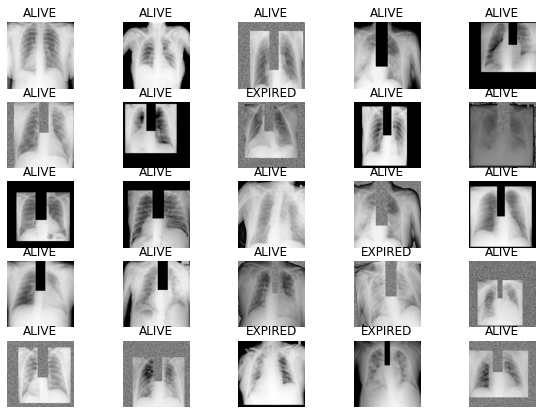

In [ ]:
structure_batch, image_batch = structure_image_batch
show_batch(image_batch, label_batch)

## Utils

In [ ]:
def calculate_f1(precision,recall):
    if precision+recall != 0:
        return 2*(precision*recall)/(precision+recall)
    else:
        return 0 #close to 0

#adapted from https://keras.io/examples/vision/xray_classification_with_tpus/
def visualize(history, outpath=None):
    metrics = ["loss","precision", "recall", "accuracy", "auc","f1"]
    fig, ax = plt.subplots(1, len(metrics), figsize=(25, 5))
    ax = ax.ravel()

    if outpath:
        fig.suptitle(outpath.split('/')[-1])

    for i, met in enumerate(metrics):
        ax[i].plot(history[met])
        ax[i].plot(history["val_" + met])
        ax[i].set_title("Model {}".format(met))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(met)
        ax[i].legend(["train", "val"])
    
    if outpath:
        plt.savefig(outpath)


# #https://keras.io/examples/vision/xray_classification_with_tpus/
# def visualize(history):
#     fig, ax = plt.subplots(1, 4, figsize=(20, 3))
#     ax = ax.ravel()

#     for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
#         ax[i].plot(history.history[met])
#         ax[i].plot(history.history["val_" + met])
#         ax[i].set_title("Model {}".format(met))
#         ax[i].set_xlabel("epochs")
#         ax[i].set_ylabel(met)
#         ax[i].legend(["train", "val"])

In [ ]:
def plot_history(results, history,params,extension='.pdf'):
    # results = ta_object.data
    # history = ta_object.round_history
    # params = ['augment_bbox', 'dropout', 'layers_not_trainable', 'lr_init', 
    #    'output_bias', 'pretrained_feature_layer','class_weight']
    for i in results.index:
        fname = []
        for p in params:
            v = results.loc[i,p]
            if type(v)==float: v=round(v,4)
            fname.append(p+str(v))
        fname = '_'.join(fname)+extension
        fname = fname.replace(':','|').replace('{','|').replace('}','|')
        fpath= os.path.join('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/figures',fname)
        visualize(history[i], outpath=fpath)


In [ ]:
# transfer learning from MIMIC -- loading to this notebook
def download_from_gcs(gcs_path, local_path):
  with tf.io.gfile.GFile(gcs_path, 'rb') as gcs_file:
    with tf.io.gfile.GFile(local_path, 'wb') as local_file:
      local_file.write(gcs_file.read())

# def load_base_model(PRETRAINED_KERAS_MODEL, compile = False, return_model=False):
#     #PRETRAINED_KERAS_MODEL = 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5' # trained on MIMIC CXR to identify CheXpert 14 labels
#     download_from_gcs(PRETRAINED_KERAS_MODEL, 'pretrained_model.h5')
#     if return_model:
#         if 'weights' in PRETRAINED_KERAS_MODEL:
#             orig_model = tf.keras.applications.DenseNet121(include_top=False)
#             orig_model.load_weights('pretrained_model.h5')
#             dim1, dim2, channel = orig_model.input.shape
#             dense_input = tf.keras.layers.Input(shape=(dim1,dim2, 1))
#             dense_filter = tf.keras.layers.Conv2D(3, 3, padding='same')(dense_input)
#             output = orig_model(dense_filter)
#             model = tf.keras.Model(dense_input, output)
#         else:
#             model = tf.keras.models.load_model('pretrained_model.h5', compile=compile)
#         return model

In [ ]:
# Saving files to gcs
def copy_file_to_gcs(job_dir, file_path):
    with file_io.FileIO(file_path, mode='rb') as input_f:
        with file_io.FileIO(os.path.join(job_dir, file_path), mode='wb+') as output_f:
            output_f.write(input_f.read())

def save_jpg_image(image, fname):
    with tf.compat.v1.Session() as sess:
        if len(image.shape)==2:
            image = np.expand_dims(image, axis=-1)
        enc = tf.image.encode_jpeg(image)
        fwrite = tf.io.write_file(tf.constant(fname), enc)
        result = sess.run(fwrite)

def export_to_gcs(f, filename, exportdir):
    if not os.path.isdir(exportdir):
        os.makedirs(exportdir)
    copy = True
    if filename[-4:] == '.csv':
        f.to_csv(filename, index=False)
    elif filename[-4:] == '.txt':
        f.to_csv(filename, sep='\t', index=False)
    elif filename[-3:] == '.h5':
        f.save(filename)
    elif filename[-4:] == '.jpg':
        save_jpg_image(f, filename)
        copy = False
    else:
        copy = False
    if copy:
        copy_file_to_gcs(exportdir, filename)

def get_best_model(scan_results, metric):
    tf.keras.backend.clear_session()
    model_id = scan_results.data[metric].astype('float').argmax() - 1
    model = model_from_json(scan_results.saved_models[model_id])
    model.set_weights(scan_results.saved_weights[model_id])
    return model

# # e.g.
# bbox_clean224.to_csv('bboxes_cleaned_224x224_plus_original.csv', index=False)
# copy_file_to_gcs('gs://new_cxr_30/bboxes/','bboxes_cleaned_224x224_plus_original.csv')
# bbox_clean320.to_csv('bboxes_cleaned_320x320_plus_original.csv', index=False)
# copy_file_to_gcs('gs://new_cxr_30/bboxes/','bboxes_cleaned_320x320_plus_original.csv')
# bboxes320_for_augment.to_csv('bboxes_cleaned_320x320_for_augment.csv', index=False)
# copy_file_to_gcs('gs://new_cxr_30/bboxes/','bboxes_cleaned_320x320_for_augment.csv')

## Define structure/tabular model

In [ ]:
# Model that uses structured data only for prediction
class TabularModel(tf.keras.Model):

  def __init__(self, input_dim, drop_out, out_dim=128, combine = False, train=True):
    super(TabularModel, self).__init__()
    self.train = train
    self.combine = combine
    self.norm1 =  tf.keras.layers.BatchNormalization(axis=1)
    self.dense0 = tf.keras.layers.Dense(input_dim, activation='relu')
    self.dense1 = tf.keras.layers.Dense(64, activation='relu')
    # drop out earlier might deal with potential missing values
    self.drop1 = tf.keras.layers.Dropout(drop_out)
    self.dense2 = tf.keras.layers.Dense(out_dim, activation='relu', name = 'dense128')
    if not combine:
        # binary prediction from structured data alone
        self.pred = tf.keras.layers.Dense(1, activation='sigmoid', name="pred_tab")

  def call(self, inputs):
    x = self.norm1(inputs)
    x = self.dense0(x)
    x = self.dense1(x)
    x = self.drop1(x, training=self.train)
    x = self.dense2(x)
    if self.combine:
        return x
    else:
        return self.pred(x)

In [ ]:
def TabularModel_functional(input_dim, drop_out, out_dim=128, output_bias = None, combine = False):
    inputs = tf.keras.Input(shape=(input_dim,), name = 'tab_input')
    x = tf.keras.layers.BatchNormalization()(inputs) # see if helps or not
    x = tf.keras.layers.Dense(input_dim, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(drop_out)(x)
    out = tf.keras.layers.Dense(out_dim, activation='relu', name = 'dense128')(x)
    if not combine:
        output_bias = tf.keras.initializers.Constant(output_bias)
        pred = tf.keras.layers.Dense(1, activation='sigmoid', name="pred_tab", bias_initializer=output_bias)(out)
        model = tf.keras.Model(inputs=inputs, outputs=pred)
    # for fusion
    else:
        model = tf.keras.Model(inputs=inputs, outputs=out)
    return model

## Define CXR image only model

In [ ]:
# Model that uses only CXR image for prediction -- shoud be same as what Po-Chi did before if combine =False
class CXRModel(tf.keras.Model):

  def __init__(self, drop_out, layers_not_trainable, out_dim=128, combine = False, train=True):
    super(CXRModel, self).__init__()
    self.train = train
    self.combine = combine
    base = tf.keras.models.load_model('pretrained_model.h5', compile=False)
    # Setting earlier layers not trainable
    for layer in base.layers[:layers_not_trainable]: # this can possibly be tuned
        layer.trainable=False  
    self.base_model = tf.keras.Model(inputs=base.input, outputs=base.layers[-2].output)
    # binary prediction from cxr alone
    if not combine:
        self.pred = tf.keras.layers.Dense(1, activation='sigmoid', name="pred_cxr")
    else:
        # Additional layers before concatenation with structured so more similar feature sizes
        # self.dense512 = tf.keras.layers.Dense(512, activation = 'relu', name="dense512")
        # self.drop1 = tf.keras.layers.Dropout(drop_out) 
        self.dense = tf.keras.layers.Dense(out_dim, activation = 'relu', name="dense"+str(out_dim))

  def call(self, inputs):
    x = self.base_model(inputs)
    if not self.combine:
        return self.pred(x)
    else:
        # x = self.dense512(x)
        # x = self.drop1(x, training=self.train)
        x = self.dense(x)
        return x

        

In [ ]:
#adapted from
import importlib
# from keras.layers import Input
# from keras.layers.core import Dense
# from keras.models import Model

class ModelFactory:
    """
    Model facotry for Keras default models
    """

    def __init__(self):
        self.models_ = dict(
            VGG16=dict(
                input_shape=(224, 224, 3),
                module_name="vgg16",
                last_conv_layer="block5_conv3",
            ),
            VGG19=dict(
                input_shape=(224, 224, 3),
                module_name="vgg19",
                last_conv_layer="block5_conv4",
            ),
            DenseNet121=dict(
                input_shape=(224, 224, 3),
                module_name="densenet",
                last_conv_layer="bn",
            ),
            ResNet50=dict(
                input_shape=(224, 224, 3),
                module_name="resnet50",
                last_conv_layer="activation_49",
            ),
            InceptionV3=dict(
                input_shape=(299, 299, 3),
                module_name="inception_v3",
                last_conv_layer="mixed10",
            ),
            InceptionResNetV2=dict(
                input_shape=(299, 299, 3),
                module_name="inception_resnet_v2",
                last_conv_layer="conv_7b_ac",
            ),
            NASNetMobile=dict(
                input_shape=(224, 224, 3),
                module_name="nasnet",
                last_conv_layer="activation_188",
            ),
            NASNetLarge=dict(
                input_shape=(331, 331, 3),
                module_name="nasnet",
                last_conv_layer="activation_260",
            ),
        )

    def get_last_conv_layer(self, model_name):
        return self.models_[model_name]["last_conv_layer"]

    def get_input_size(self, model_name):
        return self.models_[model_name]["input_shape"][:2]

    def get_model(self, class_num, model_name="DenseNet121", use_base_weights=True,
                  weights_path=None, input_shape=None):

        if use_base_weights is True:
            base_weights = "imagenet"
        else:
            base_weights = None

        base_model_class = getattr(
            importlib.import_module(
                f"keras.applications.{self.models_[model_name]['module_name']}"
            ),
            model_name)

        if input_shape is None:
            input_shape = self.models_[model_name]["input_shape"]

        img_input = tf.keras.layers.Input(shape=input_shape)

        base_model = base_model_class(
            include_top=False,
            input_tensor=img_input,
            input_shape=input_shape,
            weights=base_weights,
            pooling="avg")
        x = base_model.output
        predictions = tf.keras.layers.Dense(class_num, activation="sigmoid", name="predictions")(x)
        model = tf.keras.models.Model(inputs=img_input, outputs=predictions)

        if weights_path == "":
            weights_path = None

        if weights_path is not None:
            print(f"load model weights_path: {weights_path}")
            model.load_weights(weights_path)
        return model


In [ ]:
def load_base_model(PRETRAINED_KERAS_MODEL, compile = False, return_model=True):
    #PRETRAINED_KERAS_MODEL = 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5' # trained on MIMIC CXR to identify CheXpert 14 labels
    local_fname = PRETRAINED_KERAS_MODEL.split('/')[-1]
    if not tf.io.gfile.exists(local_fname):
        print('download file from GCS')
        download_from_gcs(PRETRAINED_KERAS_MODEL, local_fname)
    if return_model:
        if 'weights' in PRETRAINED_KERAS_MODEL:
            factory = ModelFactory()
            model = factory.get_model(class_num = 14
                                    , weights_path = local_fname)
        else:
            model = tf.keras.models.load_model(local_fname, compile=compile)
        return model

def change_model_input_layer(orig_model, channel_num=1):
    #print(orig_model.input.shape)
    orig_shape = orig_model.input.shape
    dense_input = tf.keras.layers.Input(shape=(orig_shape[1],orig_shape[2], channel_num))
    dense_filter = tf.keras.layers.Conv2D(3, 3, padding='same')(dense_input)
    output = orig_model(dense_filter)
    model = tf.keras.Model(dense_input, output)
    return model

In [ ]:
def CXRModel_functional(base_model, drop_out, layers_not_trainable, pretrained_feature_layer = -2
                        , hidden_dims = None, output_bias = None, combine = False):
    #base = tf.keras.models.load_model('pretrained_model.h5', compile=False)
    for layer in base_model.layers[:layers_not_trainable]: # this can possibly be tuned
        layer.trainable=False  
    # feature layer
    x = base_model.layers[pretrained_feature_layer].output # batchnorm layer after convolutions and before relu activation
    # Global pooling after conv feature layers if required
    if pretrained_feature_layer < -2:
        # so many 0s with base model's ReLU layer
        x = tf.keras.layers.LeakyReLU()(x)
        # Max pooling more discriminative than average pooling
        x = tf.keras.layers.GlobalMaxPooling2D()(x)
    # Hidden dense layer(s)
    if hidden_dims != None:
        for i, dim in enumerate(hidden_dims):
            a = tf.keras.layers.LeakyReLU()(x)
            x = tf.keras.layers.Dense(dim, name="dense"+str(i)+"_"+str(dim))(a)
    # x = tf.keras.layers.LeakyReLU()(x)
    # out = tf.keras.layers.Dense(out_dim, name="dense_out"+str(out_dim))(x)
    # not sure if this dropout layer is helpful or not
    out = tf.keras.layers.Dropout(drop_out)(x)
    if not combine: 
        if output_bias != None:
            output_bias = tf.keras.initializers.Constant(output_bias)
            pred = tf.keras.layers.Dense(1, activation='sigmoid', name="pred_cxr", bias_initializer=output_bias)(out)
        else:
            pred = tf.keras.layers.Dense(1, activation='sigmoid', name="pred_cxr")(out)
        model = tf.keras.Model(inputs=base_model.input, outputs=pred)
    # for fusion
    else:
        model = tf.keras.Model(inputs=base_model.input, outputs=out)
    if model.input.shape[-1] == 3:
        model = change_model_input_layer(model)
    return model

In [ ]:
model_teacher = 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5'
base_model = load_base_model(model_teacher, return_model=True)
# base_model.summary()

CXRmodel = CXRModel_functional(base_model, 0.1, 355,hidden_dims=[128,64])
CXRmodel.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 326, 326, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
model_teacher = 'gs://first_cxr/model/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
base_model = load_base_model(model_teacher, return_model=True)
CXRmodel = CXRModel_functional(base_model, 0.1, 355, pretrained_feature_layer =-4)
CXRmodel.summary()

load model weights_path: brucechou1983_CheXNet_Keras_0.3.0_weights.h5
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 3)       30        
_________________________________________________________________
model_2 (Functional)         (None, 1)                 7038529   
Total params: 7,038,559
Trainable params: 1,476,703
Non-trainable params: 5,561,856
_________________________________________________________________


In [ ]:
# maybe we're not getting the best feature layers
# https://github.com/fg91/visualizing-cnn-feature-maps/blob/master/filter_visualizer.ipynb
# https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030

## Define Intermediate Fusion model

In [ ]:
# Intermediate/Late Fusion model
class Combined_Model(tf.keras.Model):

  def __init__(self, tab_input_dim, drop_out, layers_not_trainable, tab_out_dim, cxr_out_dim, train=True):
    super(Combined_Model, self).__init__()
    self.train = train
    self.cxr_out = CXRModel(drop_out, layers_not_trainable, out_dim=cxr_out_dim, combine=True, train = train)
    self.tab_out = TabularModel(tab_input_dim, drop_out, out_dim = tab_out_dim, combine=True,train = train)
    self.norm = tf.keras.layers.BatchNormalization(axis=1)
    self.dense = tf.keras.layers.Dense(tab_out_dim+cxr_out_dim, activation='relu')
    self.dropout = tf.keras.layers.Dropout(drop_out)
    # final binary classification from both structured and cxr model
    self.pred = tf.keras.layers.Dense(1, activation='sigmoid', name="pred_combined")

  def call(self, inputs):
    # Takes in (input1,input2) or [input1,input2]
    tab_inputs, cxr_inputs = inputs
    x1 = self.tab_out(tab_inputs)
    x2 = self.cxr_out(cxr_inputs)
    concat = tf.keras.layers.concatenate([x1, x2], axis=1)
    # might help with different feature scales from imaging and tab data
    x = self.norm(concat)
    x = self.dense(x)
    x = self.dropout(x, training=self.train)
    return self.pred(x)


In [ ]:
# this one works with tuning
def Combined_Model_functional(cxr_base_model, tab_input_dim, drop_out, layers_not_trainable
                              , pretrained_feature_layer, cxr_hidden_dims, tab_out_dim 
                              #, cxr_out_dim
                              , output_bias = None):
    tabmodel = TabularModel_functional(tab_input_dim, drop_out, out_dim=tab_out_dim, combine = True)
    cxrmodel = CXRModel_functional(cxr_base_model, drop_out, layers_not_trainable
                                   , pretrained_feature_layer=pretrained_feature_layer
                                   , hidden_dims = cxr_hidden_dims
                                   #, out_dim=cxr_out_dim
                                   , combine = True
                                   )
    output_bias = tf.keras.initializers.Constant(output_bias)
    x1 = tabmodel.layers[-1].output
    x2 = cxrmodel.layers[-1].output
    concat = tf.keras.layers.concatenate([x1, x2], axis=1) # for functional API
    #concat = tf.keras.layers.Concatenate(axis=1)([x1, x2]) # for sequential API
    x = tf.keras.layers.BatchNormalization(axis=1)(concat)
    x = tf.keras.layers.Dense(tab_out_dim + cxr_out_dim, activation='relu')(x)
    x = tf.keras.layers.Dropout(drop_out)(x)
    pred = tf.keras.layers.Dense(1, activation='sigmoid', name="pred_combined", bias_initializer=output_bias)(x)
    model = tf.keras.Model(inputs = [tabmodel.input, cxrmodel.input], outputs = pred)
    return model


# Tune models

In general there are several models/strategies to try:
1. RF/XGB etc for structured data that Wesley has done in another notebook
2. Late fusion from Po-Chih's transfer-learned CXR model mortality likelihood output + structured RF/XGB model
3. Intermediate offline fusion - extract CXR features with the transfer-learned CXR model then concatenate with the raw structured feature
4. Intermediate offline fusion - extract CXR features with the transfer-learned CXR model then concatenate with deep learner encoded structured features. This may be better because the weights in deep learning models and other logistic/RF models mean different things mathematically.
5. Intermediate online fusion - both weights for the CXR and the structured features are learned during training
6. Intermediate online fusion + transfer learn -- trained the CXR and structured deep learning models separately, pick the best models then fuse and learn a bit more. 5 likely works better as larger set of hyperparameters can be explored/tuned but likely less interpretable.
7. For any CXR related training, can tune for with and without Bbox augmentation for trache and lung/heart regions to help network ignore less relevant CXR features for prediction.

Po-Chih seems to be working on 3

This notebook is trying to do 5 with 7

It would be reasonable to try to do 2 as well

For testing on external data (Korean & Hoboken), CXR features have already been extracted for 3. To test the models from this notebook, one would need to package the final models and get help from Seth/Joseph to run on the Hoboken dataset 




### Training/Tuning code

In [ ]:
# # Tuning function adapted from
# # https://github.com/cxr-eye-gaze/eye-gaze-dataset/blob/master/Experiments/tune_static.py
# # https://github.com/ray-project/ray/blob/master/python/ray/tune/examples/tune_mnist_keras.py
# # https://keras.io/examples/vision/xray_classification_with_tpus/ 
# # https://colab.research.google.com/drive/1kpCDInclZHLOvb-9MOgQHUfJfsg8748Z#scrollTo=ZbJDZ6chSWOb

# def tune_covid19_models(x_train, y_train, x_val, y_val, config):
#     tf.keras.backend.clear_session()
    
#     print(config)
#     # args
#     args = type('', (), {})()
#     # Hyperparameters that can be tuned
#     args.model_type = config['model_type'] #'tab_model','cxr_model','model_fused'
#     args.tab_out_dim = config['tab_out_dim']
#     args.cxr_out_dim = config['cxr_out_dim']
#     args.augment_bbox = config['augment_bbox']
#     args.model_teacher = config['model_teacher']
#     args.lr_init = config['lr_init']
#     args.epochs = config["epochs"]
#     args.dropout = config['dropout']
#     args.batch_size = config['batch_size']
#     args.class_weight = config['class_weight']
#     args.layers_not_trainable = config['layers_not_trainable']
#     args.pretrained_feature_layer = config['pretrained_feature_layer']
#     args.cxr_hidden_dims = config['cxr_hidden_dims']

#     args.steps_per_epoch = int(len(training_filenames)) // args.batch_size
#     args.val_steps = int(len(validation_filenames)) // args.batch_size
#     print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(args.batch_size, args.steps_per_epoch, args.val_steps))

#     # input and output parameters
#     args.train_table_path = 'gs://new_cxr_30/split/train_structured.csv'
#     args.valid_table_path = 'gs://new_cxr_30/split/valtest_structured.csv'
#     args.test_table_path = 'gs://new_cxr_30/split/test_structured.csv'
#     args.xfeatures = XFEATURES
#     args.image_path_train = 'gs://new_cxr_30/classified/*/train_*.jpg'
#     args.image_path_test = 'gs://new_cxr_30/classified/*/test_*.jpg' 
#     args.resize = TARGET_SIZE
#     args.num_workers = 16 # can reduce to optimize memory
#     args.rseed = SEED
#     args.output_dir = 'gs://new_cxr_30/models/'

#     # Create saving dir, all useful variables
#     output_model_path = os.path.join(args.output_dir, args.model_type)
#     if not os.path.exists(output_model_path): 
#         os.makedirs(output_model_path)
    
#     # Load data to iterator
#     # argumetns: get_augmented_batched_dataset_(structured_path, xfeatures, model_type, batch_size, rseed, train=True)
#     train_dl = get_augmented_batched_dataset_(args.train_table_path, args.xfeatures
#                             , args.model_type, args.batch_size, args.augment_bbox, args.rseed, train=True)
#     valid_dl = get_augmented_batched_dataset_(args.valid_table_path, args.xfeatures
#                             , args.model_type, args.batch_size, False, args.rseed, train=False)
#     #test_dl = get_augmented_batched_dataset_(args.test_table_path, args.xfeatures
#                             #, args.model_type, args.batch_size, args.augment_bbox, args.rseed, train=False)
    
#     # Logs in keras -- no idea where things are being saved
#     checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(output_model_path,'model-{epoch:03d}.h5')
#                                                     , verbose=1, monitor='val_loss'
#                                                     ,save_best_only=True, mode='min')  
#     early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, verbose = 1, restore_best_weights=True)

#     # Tune learning rate
#     initial_learning_rate = config['lr_init']
#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate
#                     , decay_steps=100000, decay_rate=0.96, staircase=True)
    
#     # Need to load datasets before initializing tpu or will have address error
#     # problem:https://github.com/tensorflow/tensorflow/issues/43037
#     # solution: https://colab.research.google.com/drive/1kpCDInclZHLOvb-9MOgQHUfJfsg8748Z#scrollTo=ZbJDZ6chSWOb

#     # set tpu model strategy
#     if USE_TPU:
#         if HOSTED_RUNTIME: # but this is still giving me address error when run with eagarly executions required for bbox augmentation
#             #resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#             try:
#                 tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#             except ValueError:
#                 raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
#             # https://stackoverflow.com/questions/55541881/how-to-convert-tf-keras-model-to-tpu-using-tensorflow-2-0-in-google-colab
#         else:
#             try:
#                 tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='cxr-test',project='hm-covid-19') 
#             except ValueError:
#                 raise BaseException('ERROR: Not connected to a TPU runtime')
#         print('Hosted runtime:', HOSTED_RUNTIME)
#         print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#         tf.config.experimental_connect_to_cluster(tpu)
#         tf.tpu.experimental.initialize_tpu_system(tpu)
#         strategy = tf.distribute.experimental.TPUStrategy(tpu)
#     else:
#         strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU

#     # Compile model
#     with strategy.scope():
#         # Getting error with serializing subclassed models...which cannot be done! so changed models to functional
#         # https://stackoverflow.com/questions/51806852/cant-save-custom-subclassed-model
#         # Pick the model to fit
#         if args.model_type == 'tab_model':
#             #input: input_dim, drop+out
#             model = TabularModel_functional(len(args.xfeatures), args.dropout)
#         elif args.model_type == 'cxr_model':
#             base = load_base_model(args.model_teacher) # load base model from gb to local runtime
#             #input: drop_out, layers_not_trainable
#             model = CXRModel_functional(base, args.dropout, args.layers_not_trainable
#                                         , pretrained_feature_layer=args.pretrained_feature_layer
#                                         , hidden_dims = args.cxr_hidden_dims)
#         elif args.model_type == 'fused_model':
#             base = load_base_model(args.model_teacher) # load base model from gb to local runtime
#             #input: tab_input_dim, drop_out, layers_not_trainable, tab_out_dim, cxr_out_dim
#             model = Combined_Model_functional(base, len(args.xfeatures), args.dropout, args.layers_not_trainable
#                                         ,args.pretrained_feature_layer, args.cxr_hidden_dims
#                                         , args.tab_out_dim, args.cxr_out_dim)
#         else:
#             print('Model type does not exist')
#         METRICS = [
#                 tf.keras.metrics.BinaryAccuracy(),
#                 tf.keras.metrics.Precision(name="precision"),
#                 tf.keras.metrics.Recall(name="recall"),
#                 tf.keras.metrics.AUC(name='auc'),
#                 ]
#         model.compile(
#             #optimizer='adam',
#             optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
#             loss='binary_crossentropy',
#             metrics=METRICS,
#         )

#     # Fit the model in tf.keras...
#     history = model.fit(train_dl,
#                         steps_per_epoch = args.steps_per_epoch,
#                         epochs = args.epochs, 
#                         validation_data = valid_dl,
#                         shuffle = True,
#                         class_weight = args.class_weight, 
#                         callbacks=[checkpoint, early_stopping_cb])
    
#     # might not need this in tensorflow 2.x
#     # if USE_TPU:
#     #     return history, model #.sync_to_cpu() 
#     # else:
#     return history, model



In [ ]:
# https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

# from: https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d
def macro_double_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [ ]:
def tune_covid19_models(x_train, y_train, x_val, y_val, config):
    tf.keras.backend.clear_session()
    
    print(config)
    # args
    args = type('', (), {})()
    # Hyperparameters that can be tuned
    args.model_type = config['model_type'] #'tab_model','cxr_model','model_fused'
    args.tab_out_dim = config['tab_out_dim']
    #args.cxr_out_dim = config['cxr_out_dim'] # last hidden dim would be the cxr_out_dim so fewer search params
    args.augment_bbox = config['augment_bbox']
    args.model_teacher = config['model_teacher']
    args.lr_init = config['lr_init']
    args.epochs = config["epochs"]
    args.dropout = config['dropout']
    args.batch_size = config['batch_size']
    args.loss_function = config['loss_function']
    args.class_weight = config['class_weight']
    args.layers_not_trainable = config['layers_not_trainable']
    args.pretrained_feature_layer = config['pretrained_feature_layer']
    args.cxr_hidden_dims = config['cxr_hidden_dims']
    args.output_bias = config['output_bias']
    args.steps_per_epoch = int(len(training_filenames)) // args.batch_size
    args.val_steps = int(len(validation_filenames)) // args.batch_size
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(args.batch_size, args.steps_per_epoch, args.val_steps))
    args.fold = config['k-fold']

    # input and output parameters
    args.train_table_path = 'gs://new_cxr_30/split/train_structured.csv'
    args.valid_table_path = 'gs://new_cxr_30/split/valtest_structured.csv'
    args.test_table_path = 'gs://new_cxr_30/split/test_structured.csv'
    args.combined_table_path = 'gs://new_cxr_30/split/combined_structured.csv'
    args.xfeatures = XFEATURES
    args.image_path_train = 'gs://new_cxr_30/classified/*/train_*.jpg'
    args.image_path_test = 'gs://new_cxr_30/classified/*/test_*.jpg' 
    #args.resize = TARGET_SIZE
    args.num_workers = 16 # can reduce to optimize memory
    args.rseed = SEED
    args.output_dir = 'gs://new_cxr_30/models/'

    # Create saving dir, all useful variables
    output_model_path = os.path.join(args.output_dir, args.model_type)
    if not os.path.exists(output_model_path): 
        os.makedirs(output_model_path)
    
    # Option for k-fold splits for train/val, k=4
    if args.fold > 0:
        dfall = pd.read_csv(args.combined_table_path)
        dfvalid = dfall[dfall.fold==args.fold].copy()
        dftrain = dfall[~dfall.index.isin(dfvalid.index.tolist())].copy()
    else:
        dftrain = pd.read_csv(args.train_table_path)
        dfvalid = pd.read_csv(args.valid_table_path)

    # Need to load datasets before initializing tpu or will have address error
    # problem:https://github.com/tensorflow/tensorflow/issues/43037
    # solution: https://colab.research.google.com/drive/1kpCDInclZHLOvb-9MOgQHUfJfsg8748Z#scrollTo=ZbJDZ6chSWOb

    # Compile model
    with strategy.scope():
        # Load data to iterator
        # argumetns: get_augmented_batched_dataset_(structured_path, xfeatures, model_type, batch_size, rseed, train=True)
        train_dl = get_augmented_batched_dataset_(dftrain, args.xfeatures
                                , args.model_type, args.batch_size, args.augment_bbox, args.rseed, train=True)
        valid_dl = get_augmented_batched_dataset_(dfvalid, args.xfeatures
                                , args.model_type, args.batch_size, False, args.rseed, train=False)
        #test_dl = get_augmented_batched_dataset_(args.test_table_path, args.xfeatures
                                #, args.model_type, args.batch_size, False, args.rseed, train=False)
        
        # Logs in keras -- no idea where things are being saved
        checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(output_model_path,'model-{epoch:03d}.h5')
                                                        , verbose=1, monitor='val_auc'
                                                        ,save_best_only=True, mode='max')  
        early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode = 'max'
                                                        , verbose = 1, restore_best_weights=True)
        
        # Tune learning rate
        initial_learning_rate = config['lr_init']
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate
                        , decay_steps=100000, decay_rate=0.96, staircase=True)  
        
        # Getting error with serializing subclassed models...which cannot be done! so changed models to functional
        # https://stackoverflow.com/questions/51806852/cant-save-custom-subclassed-model
        # Pick the model to fit
        if args.model_type == 'tab_model':
            #input: input_dim, drop+out
            model = TabularModel_functional(len(args.xfeatures), args.dropout)
        elif args.model_type == 'cxr_model':
            base = load_base_model(args.model_teacher) # load base model from gb to local runtime
            #input: drop_out, layers_not_trainable
            model = CXRModel_functional(base, args.dropout, args.layers_not_trainable
                                        , pretrained_feature_layer=args.pretrained_feature_layer
                                        , hidden_dims = args.cxr_hidden_dims
                                        , output_bias = args.output_bias
                                        )
        elif args.model_type == 'fused_model':
            base = load_base_model(args.model_teacher) # load base model from gb to local runtime
            #input: tab_input_dim, drop_out, layers_not_trainable, tab_out_dim, cxr_out_dim
            model = Combined_Model_functional(base, len(args.xfeatures), args.dropout, args.layers_not_trainable
                                        ,args.pretrained_feature_layer, args.cxr_hidden_dims
                                        , args.tab_out_dim 
                                        #, args.cxr_out_dim
                                        , output_bias = args.output_bias
                                        )
        else:
            print('Model type does not exist')
        METRICS = [
                tf.keras.metrics.TruePositives(name='tp'),
                tf.keras.metrics.FalsePositives(name='fp'),
                tf.keras.metrics.TrueNegatives(name='tn'),
                tf.keras.metrics.FalseNegatives(name='fn'), 
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                tf.keras.metrics.AUC(name='auc'),
                f1,
                #tfa.metrics.F1Score(2, name='f1_score') # gives an error
                ]
        
        # likely do better for imbalanced data: https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy
        if args.loss_function == 'sigmoid_focal_crossentropy':
            loss = tfa.losses.SigmoidFocalCrossEntropy()
        elif args.loss_function == 'f1_loss':  
            loss = f1_loss
        elif args.loss_function == 'macro_double_soft_f1':
            loss = macro_double_soft_f1
        else:
            loss = args.loss_function
        
        model.compile(
            #optimizer='adam',
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=loss,
            metrics=METRICS,
        )

    # Fit the model in tf.keras...
    history = model.fit(train_dl,
                        steps_per_epoch = args.steps_per_epoch // 10,
                        epochs = args.epochs * 10, 
                        validation_data = valid_dl,
                        shuffle = True,
                        class_weight = args.class_weight, 
                        callbacks=[checkpoint, early_stopping_cb]
                        )
    
    # Visualize
    
    # might not need this in tensorflow 2.x
    # if USE_TPU:
    #     return history, model #.sync_to_cpu() 
    # else:
    return history, model




## Tunable parameters

In [ ]:
# Po-Chih noted that on Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)
BATCH_SIZE = [16] # most models performed better on 16 and there are usually 1-2 examples in each batch of 16

# Even though bias inialization usually doesn't matter for large CNN networks
# We're actually mostly tuning only the last few layers of the pretrained CNN
# And our data is very imbalanced
# so maybe more careful initialization bias in the last neural layer is useful particularly for precision
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
GCS_PATTERN_JPG = 'gs://new_cxr_30/classified/*/*.jpg'
imagefilenames = tf.io.gfile.glob(GCS_PATTERN_JPG)
pos = len([x for x in imagefilenames if 'EXPIRED' in x])
neg = len([x for x in imagefilenames if 'ALIVE' in x])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
initial_bias = np.log([pos/neg])
BIAS = [initial_bias]

# Very unbalanced training data so will use class weights. 1 is expired, added weight to boost the expired cases
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
print('Calculated weight for class 0: {:.2f}'.format(weight_for_0))
print('Calculated weight for class 1: {:.2f}'.format(weight_for_1))
cw_calculated = {0: weight_for_0, 1: weight_for_1}
# For best recall/AUC, cw_calculated is likely most helpful, but would be worst for precision (best if no class weight)
CLASS_WEIGHT = [cw_calculated, {0:10 , 1:10}]

# Other tunable parameters
DROPOUT = [0.1, 0.3, 0.5]
EPOCHS = [30] # up to this number of epochs -- have early stopping
LR_INIT = [0.001, 0.003, 0.009]
AUGMENT_BBOX = [False, 'B']

# Not Tunable layers for pretrained model
LAYERS_NOT_TRAINABLE = [355, 400]

# feature layer from the pretrained cxr model
PRETRAINED_FEATURE_LAYER = [-2, -4]

# Can try hidden dims
CXR_HIDDEN_DIMS = [[128],[128,64],[128,128]]

# Dimension of concat layer for fusion model: 
structured_feature_size = int(len(XFEATURES))
print(structured_feature_size)
TAB_OUT_DIM = [structured_feature_size, 64]
#CXR_OUT_DIM = [structured_feature_size, 64]

# May want a different loss function than binary cross entropy loss
LOSS = ['binary_crossentropy','sigmoid_focal_crossentropy']

Examples:
    Total: 1850
    Positive: 207 (11.19% of total)

Calculated weight for class 0: 0.56
Calculated weight for class 1: 4.47
45


In [ ]:
search_num_tab = len(BATCH_SIZE)*len(CLASS_WEIGHT)*len(DROPOUT)*len(EPOCHS)*len(LR_INIT)
print(search_num_tab)

search_num_cxr = len(BATCH_SIZE)*len(CLASS_WEIGHT)*len(DROPOUT)*len(EPOCHS)*len(LR_INIT)*len(AUGMENT_BBOX)*len(LAYERS_NOT_TRAINABLE)*len(PRETRAINED_FEATURE_LAYER)*len(BIAS)*len(CXR_HIDDEN_DIMS)*len(LOSS)
print(search_num_cxr)

search_num_fused = len(BATCH_SIZE)*len(CLASS_WEIGHT)*len(DROPOUT)*len(EPOCHS)*len(LR_INIT)*len(AUGMENT_BBOX)*len(LAYERS_NOT_TRAINABLE)*len(TAB_OUT_DIM)*len(PRETRAINED_FEATURE_LAYER)*len(BIAS)*len(CXR_HIDDEN_DIMS)
print(search_num_fused)

18
864
864


In [ ]:
# Get consistent folds in case random state seed didn't work

# train_table_path = 'gs://new_cxr_30/split/train_structured.csv'
# valid_table_path = 'gs://new_cxr_30/split/valtest_structured.csv'
# dftrain = pd.read_csv(train_table_path)
# dfvalid = pd.read_csv(valid_table_path)
# print(len(dfvalid))
# dftrain = dftrain.sample(frac=1,random_state=42).reset_index(drop=True).copy()
# dfvalid = dfvalid.sample(frac=1,random_state=42).reset_index(drop=True).copy()
# dfall = pd.concat([dfvalid,dftrain],ignore_index=True).copy()
# # for 4 folds of 75% / 25% train / val split with n val examples
# n = len(dfall) // k +1
# print(n)
# folds = [indices[i * n:(i + 1) * n] for i in range((len(indices) + n - 1) // n)]
# print(len(folds))
# def getfold(idx,folds):
#     for i, fold in enumerate(folds):
#         if idx in fold:
#             return i
# dfall['fold'] = [getfold(idx,folds) for idx in dfall.index.tolist()]
# # export_to_gcs(dfall, 'combined_structured.csv', 'gs://new_cxr_30/split')

dfall = pd.read_csv('gs://new_cxr_30/split/combined_structured.csv')
for i in range(4):
    print(dfall[dfall.fold==i].shape)
    print(dfall[(dfall.fold==i)&(dfall.expired_30_days==1)].shape)
dfall.head()



(463, 53)
(43, 53)
(463, 53)
(58, 53)
(463, 53)
(49, 53)
(461, 53)
(57, 53)


,Unnamed: 0,SOPInstanceUID,path,expired_30_days,patient_id,age,MALE,vitals_temp_ed_first,vitals_sbp_ed_first,vitals_dbp_ed_first,...,lab_leukocyte,lab_alt,lab_ast,lab_ddimer,lab_neutrophil_percentage,lab_crp,lab_hemoglobin,APview,bbox_coordinates,fold
0,304,1.3.51.0.7.181565542.25952.64328.34017.44892.5...,gs://new_cxr_30/classified/ALIVE/test_1.3.51.0...,0,738.0,-1.500000,1.0,0.666667,0.000000,0.0,...,-0.793133,4.534202,4.938023,0.000000,-0.563910,-0.454840,0.470588,1,"[135, 29, 178, 164, 11, 50, 298, 303]",0
1,39,1.3.12.2.1107.5.3.56.2693.11.202003271231300687,gs://new_cxr_30/classified/ALIVE/test_1.3.12.2...,0,1026.0,-0.916667,1.0,0.833333,-0.266667,0.0,...,-0.315880,0.084691,0.804020,-0.293578,0.578947,1.434851,0.058824,1,"[120, 34, 162, 148, 9, 46, 288, 238]",0
2,341,1.3.51.0.7.3412060171.33033.63557.36001.21862....,gs://new_cxr_30/classified/ALIVE/test_1.3.51.0...,0,2433.0,0.458333,1.0,0.000000,-2.733333,-1.0,...,0.563090,0.000000,0.000000,-0.988003,0.812030,-0.587801,-0.411765,1,"[135, 29, 178, 166, 39, 58, 294, 283]",0
3,218,1.3.51.0.7.12213814209.18309.19527.45079.23149...,gs://new_cxr_30/classified/ALIVE/test_1.3.51.0...,0,2469.0,-0.375000,1.0,0.000000,0.000000,0.0,...,0.082403,-0.182410,-0.951424,-1.013409,-0.992481,-0.830622,0.117647,1,"[152, 29, 187, 163, 42, 71, 312, 266]",0
4,155,1.3.46.670589.30.36.0.1.18774111139.1586155491...,gs://new_cxr_30/classified/ALIVE/test_1.3.46.6...,0,1117.0,0.291667,0.0,-1.500000,1.333333,1.5,...,0.230043,-0.312704,-0.067002,-0.115737,-0.729323,-0.520294,-2.823529,1,"[169, 29, 204, 157, 49, 66, 272, 241]",0


# Different experiment set ups

## Tuning CXR model experiments with 320 pretrained model

In [ ]:
# documentations

# report1 -- 71 experiments but the CXR network didn't actually have a drop out layer so actually fewer combinations
# report2 -- reran the 71 experiments with drop out but very bad results for almost all likely to due to vanishing features/gradients after relu/maxpool layer
# report3 -- runing with 0 dropout but testing different baseline input feature layers and changed relu to leaky relu


In [ ]:
# pretrained CXR model input image width/height
TARGET_SIZE = 320
MODEL_TEACHER = ['gs://first_cxr/model/mimic_gen_aug_epoch5.h5'] # 320x320 input

# Rough Manual Hyperparameter search space
# Slower learning rate and bias seem to help with smoother learning curves. Need more drop out to reduce overfitting.
# Increasing batch size didn't help like Po-Chih found out
# Class weighting helps recall and AUC but not precision as expected
cxr_search_space = {
    "batch_size": BATCH_SIZE,
    "class_weight": CLASS_WEIGHT,
    "dropout": [0.1,0.3,0.5],
    "epochs": EPOCHS,
    "lr_init": [0.001, 0.003, 0.009],
    "loss_function": ['sigmoid_focal_crossentropy'],
    "model_type": ['cxr_model'],
    "tab_out_dim": [1],
    "cxr_hidden_dims": [None],
    "output_bias": BIAS, #[None, initial_bias],
    "layers_not_trainable": [355,400], # max layers 428 for Po-Chi's base cxr model
    'pretrained_feature_layer': [-4,-2],
    "augment_bbox": ['B'], #[False]
    "model_teacher": MODEL_TEACHER,
    "k-fold":[0],
}

# # Narrowed down on these Hyperparameter search spaces -288 experiments
# cxr_search_space = {
#     "batch_size": BATCH_SIZE,
#     "class_weight": CLASS_WEIGHT,
#     "dropout": DROPOUT,
#     "epochs": EPOCHS,
#     "lr_init": LR_INIT,
#     "model_type": ['cxr_model'],
#     "tab_out_dim": [1],
#     "cxr_hidden_dims": CXR_HIDDEN_DIMS,
#     "output_bias": BIAS,
#     "layers_not_trainable": LAYERS_NOT_TRAINABLE, # max layers 428 for Po-Chi's base cxr model
#     'pretrained_feature_layer': PRETRAINED_FEATURE_LAYER,
#     "augment_bbox": AUGMENT_BBOX,
#     "model_teacher": MODEL_TEACHER,
#     "k-fold":[0],
# }


cxr_search_space = {
    "batch_size": BATCH_SIZE,
    "class_weight": CLASS_WEIGHT,
    "dropout": [0.5],
    "epochs": [40],
    "lr_init": [0.001, 0.003, 0.009],
    "loss_function": ['binary_crossentropy'], # both pretty bad -- not learning at all
    "model_type": ['cxr_model'],
    "tab_out_dim": [1],
    "cxr_hidden_dims": CXR_HIDDEN_DIMS,
    "output_bias": BIAS, #[None, initial_bias],
    "layers_not_trainable": [355,400], # max layers 428 for Po-Chi's base cxr model
    'pretrained_feature_layer': [-2,-4],
    "augment_bbox": ['B'], #[False]
    "model_teacher": MODEL_TEACHER,
    "k-fold":[0],
}

cxr_search_space = {
    "batch_size": BATCH_SIZE,
    "class_weight": [{0:10 , 1:10}],
    "dropout": [0.5],
    "epochs": [50],
    "lr_init": [0.001,0.002,0.003],
    "loss_function": ['binary_crossentropy'], 
    "model_type": ['cxr_model'],
    "tab_out_dim": [1],
    "cxr_hidden_dims": [[128,64]],
    "output_bias": [initial_bias], #[None, initial_bias],
    "layers_not_trainable": [400], # max layers 428 for Po-Chi's base cxr model
    'pretrained_feature_layer': [-2, -4],
    "augment_bbox": ['B'],
    "model_teacher": MODEL_TEACHER,
    "k-fold":[0,1,2,3],
}

# https://towardsdatascience.com/smart-hyperparameter-optimization-of-any-deep-learning-model-using-tpu-and-talos-9eb48d09d637
with CustomObjectScope({'GlorotUniform': tf.keras.initializers.glorot_uniform()}):
    cxr320 = ta.Scan(x='x', y='y', x_val= 'xval',y_val= 'yval', # seems to be required input args but irrelevant for tune_coviv19_models i think
                        model=tune_covid19_models,
                        params=cxr_search_space,
                        experiment_name='tune_covid19_models')

  0%|          | 0/24 [00:00<?, ?it/s]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 0, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.001, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -2, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 33s 3s/step - loss: 11.0066 - tp: 0.4444 - fp: 3.4444 - tn: 63.7778 - fn: 10.5556 - accuracy: 0.8281 - precision: 0.0444 - recall: 0.0222 - auc: 0.3724 - f1: 0.0111 - val_loss: 0.3146 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 414.0000 - val_fn: 43.0000 - val_accuracy: 0.9059 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4808 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.48079, s

  4%|▍         | 1/24 [12:21<4:44:12, 741.40s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 0, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.001, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -4, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 8.2475 - tp: 1.4444 - fp: 4.6667 - tn: 62.5556 - fn: 9.5556 - accuracy: 0.8467 - precision: 0.1071 - recall: 0.0811 - auc: 0.3796 - f1: 0.0462 - val_loss: 0.3093 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 414.0000 - val_fn: 43.0000 - val_accuracy: 0.9059 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6866 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.68658, sav

  8%|▊         | 2/24 [25:10<4:37:42, 757.40s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 0, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.002, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -2, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 12.4670 - tp: 1.5556 - fp: 6.4444 - tn: 60.7778 - fn: 9.4444 - accuracy: 0.8288 - precision: 0.1090 - recall: 0.1008 - auc: 0.3414 - f1: 0.0508 - val_loss: 0.3168 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 414.0000 - val_fn: 43.0000 - val_accuracy: 0.9059 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5619 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.56188, sa

 12%|█▎        | 3/24 [39:48<4:44:26, 812.70s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 0, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.002, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -4, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 15.6838 - tp: 0.2222 - fp: 6.1111 - tn: 61.1111 - fn: 10.7778 - accuracy: 0.7814 - precision: 0.0171 - recall: 0.0111 - auc: 0.3372 - f1: 0.0062 - val_loss: 0.3235 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 414.0000 - val_fn: 43.0000 - val_accuracy: 0.9059 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6055 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.60547, s

 17%|█▋        | 4/24 [51:52<4:19:14, 777.73s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 0, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.003, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -2, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 14.5041 - tp: 1.2222 - fp: 6.7778 - tn: 60.4444 - fn: 9.7778 - accuracy: 0.8190 - precision: 0.1008 - recall: 0.0885 - auc: 0.3432 - f1: 0.0531 - val_loss: 0.2995 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 414.0000 - val_fn: 43.0000 - val_accuracy: 0.9059 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7548 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.75480, sa

 21%|██        | 5/24 [1:03:39<3:58:12, 752.22s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 0, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.003, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -4, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 17.4837 - tp: 1.3333 - fp: 7.4444 - tn: 59.7778 - fn: 9.6667 - accuracy: 0.7888 - precision: 0.0939 - recall: 0.0772 - auc: 0.3416 - f1: 0.0621 - val_loss: 0.3022 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 414.0000 - val_fn: 43.0000 - val_accuracy: 0.9059 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7917 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.79165, sa

 25%|██▌       | 6/24 [1:13:47<3:30:58, 703.26s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 1, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.001, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -2, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 5.8636 - tp: 0.4444 - fp: 4.8889 - tn: 63.8889 - fn: 9.0000 - accuracy: 0.8078 - precision: 0.0564 - recall: 0.0314 - auc: 0.5851 - f1: 0.0207 - val_loss: 0.3848 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 405.0000 - val_fn: 58.0000 - val_accuracy: 0.8747 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6290 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.62897, sav

 29%|██▉       | 7/24 [1:26:01<3:22:06, 713.35s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 1, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.001, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -4, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 7.1643 - tp: 0.7778 - fp: 7.6667 - tn: 61.1111 - fn: 8.6667 - accuracy: 0.7661 - precision: 0.0713 - recall: 0.0592 - auc: 0.5500 - f1: 0.0923 - val_loss: 0.3697 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 405.0000 - val_fn: 58.0000 - val_accuracy: 0.8747 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6332 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.63316, sav

 33%|███▎      | 8/24 [1:34:52<2:54:40, 655.03s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 1, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.002, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -2, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 8.5432 - tp: 1.8889 - fp: 4.7778 - tn: 64.0000 - fn: 7.5556 - accuracy: 0.8442 - precision: 0.3068 - recall: 0.2258 - auc: 0.6237 - f1: 0.1540 - val_loss: 0.3719 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 405.0000 - val_fn: 58.0000 - val_accuracy: 0.8747 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7203 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.72035, sav

 38%|███▊      | 9/24 [1:45:05<2:40:28, 641.88s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 1, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.002, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -4, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 7.7712 - tp: 2.3333 - fp: 5.4444 - tn: 63.3333 - fn: 7.1111 - accuracy: 0.8444 - precision: 0.3518 - recall: 0.2509 - auc: 0.6306 - f1: 0.2728 - val_loss: 0.3774 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 405.0000 - val_fn: 58.0000 - val_accuracy: 0.8747 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6128 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.61275, sav

 42%|████▏     | 10/24 [1:55:48<2:29:52, 642.34s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 1, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.003, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -2, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 8.5721 - tp: 0.6667 - fp: 5.0000 - tn: 63.7778 - fn: 8.7778 - accuracy: 0.8255 - precision: 0.0714 - recall: 0.0453 - auc: 0.5064 - f1: 0.0403 - val_loss: 0.3940 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 405.0000 - val_fn: 58.0000 - val_accuracy: 0.8747 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6756 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.67559, sav

 46%|████▌     | 11/24 [2:07:10<2:21:49, 654.57s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 1, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.003, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -4, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 11.5294 - tp: 1.3333 - fp: 9.2222 - tn: 59.5556 - fn: 8.1111 - accuracy: 0.7453 - precision: 0.0775 - recall: 0.0879 - auc: 0.5354 - f1: 0.0522 - val_loss: 0.3814 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 405.0000 - val_fn: 58.0000 - val_accuracy: 0.8747 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7045 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.70453, sa

 50%|█████     | 12/24 [2:17:09<2:07:31, 637.59s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 2, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.001, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -2, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 33s 3s/step - loss: 9.7554 - tp: 1.7778 - fp: 12.8889 - tn: 55.8889 - fn: 7.6667 - accuracy: 0.7099 - precision: 0.1100 - recall: 0.1903 - auc: 0.5229 - f1: 0.0585 - val_loss: 0.3330 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 414.0000 - val_fn: 49.0000 - val_accuracy: 0.8942 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7670 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.76696, sa

 54%|█████▍    | 13/24 [2:35:54<2:23:58, 785.29s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 2, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.001, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -4, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 32s 3s/step - loss: 7.2454 - tp: 0.0000e+00 - fp: 8.4444 - tn: 60.3333 - fn: 9.4444 - accuracy: 0.7044 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5138 - f1: 0.0000e+00 - val_loss: 0.3308 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 414.0000 - val_fn: 49.0000 - val_accuracy: 0.8942 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7900 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf

 58%|█████▊    | 14/24 [2:43:52<1:55:25, 692.58s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 2, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.002, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -2, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 32s 3s/step - loss: 5.4171 - tp: 0.6667 - fp: 3.8889 - tn: 64.8889 - fn: 8.7778 - accuracy: 0.8151 - precision: 0.1296 - recall: 0.0608 - auc: 0.6512 - f1: 0.1122 - val_loss: 0.3227 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 414.0000 - val_fn: 49.0000 - val_accuracy: 0.8942 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7934 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.79343, sav

 62%|██████▎   | 15/24 [2:50:15<1:29:52, 599.15s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 2, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.002, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -4, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 10.1923 - tp: 0.0000e+00 - fp: 8.4444 - tn: 60.3333 - fn: 9.4444 - accuracy: 0.7410 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5983 - f1: 0.0000e+00 - val_loss: 0.3382 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 414.0000 - val_fn: 49.0000 - val_accuracy: 0.8942 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7570 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -in

 67%|██████▋   | 16/24 [2:56:21<1:10:32, 529.04s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 2, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.003, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -2, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 32s 3s/step - loss: 33.3036 - tp: 2.6667 - fp: 20.1111 - tn: 48.6667 - fn: 6.7778 - accuracy: 0.6353 - precision: 0.1073 - recall: 0.2854 - auc: 0.5179 - f1: 0.0647 - val_loss: 0.3919 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 414.0000 - val_fn: 49.0000 - val_accuracy: 0.8942 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7190 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.71904, s

 71%|███████   | 17/24 [3:01:51<54:43, 469.02s/it]  

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 2, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.003, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -4, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 33s 3s/step - loss: 12.1921 - tp: 0.0000e+00 - fp: 9.5556 - tn: 59.2222 - fn: 9.4444 - accuracy: 0.7435 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5611 - f1: 0.0000e+00 - val_loss: 0.3350 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 414.0000 - val_fn: 49.0000 - val_accuracy: 0.8942 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7656 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -in

 75%|███████▌  | 18/24 [3:09:14<46:08, 461.38s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 3, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.001, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -2, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 32s 3s/step - loss: 5.5897 - tp: 0.0000e+00 - fp: 4.0000 - tn: 69.0000 - fn: 5.2222 - accuracy: 0.8379 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5402 - f1: 0.0000e+00 - val_loss: 0.3686 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 404.0000 - val_fn: 57.0000 - val_accuracy: 0.8764 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7317 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf

 79%|███████▉  | 19/24 [3:24:42<50:06, 601.34s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 3, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.001, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -4, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 32s 3s/step - loss: 6.0713 - tp: 1.0000 - fp: 6.0000 - tn: 67.0000 - fn: 4.2222 - accuracy: 0.8182 - precision: 0.1429 - recall: 0.2130 - auc: 0.6840 - f1: 0.0632 - val_loss: 0.4038 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 404.0000 - val_fn: 57.0000 - val_accuracy: 0.8764 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7116 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.71157, sav

 83%|████████▎ | 20/24 [3:36:50<42:37, 639.33s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 3, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.002, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -2, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 6.6668 - tp: 1.0000 - fp: 4.0000 - tn: 69.0000 - fn: 4.2222 - accuracy: 0.8577 - precision: 0.2000 - recall: 0.2130 - auc: 0.7116 - f1: 0.0790 - val_loss: 0.3686 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 404.0000 - val_fn: 57.0000 - val_accuracy: 0.8764 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7295 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.72948, sav

 88%|████████▊ | 21/24 [3:50:17<34:28, 689.63s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 3, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.002, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -4, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 32s 3s/step - loss: 6.0646 - tp: 2.0000 - fp: 2.4444 - tn: 70.5556 - fn: 3.2222 - accuracy: 0.9130 - precision: 0.4556 - recall: 0.4259 - auc: 0.7364 - f1: 0.1805 - val_loss: 0.3818 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 404.0000 - val_fn: 57.0000 - val_accuracy: 0.8764 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7400 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.73997, sav

 92%|█████████▏| 22/24 [4:01:36<22:53, 686.62s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 3, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.003, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -2, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 23.2353 - tp: 0.7778 - fp: 18.1111 - tn: 54.8889 - fn: 4.4444 - accuracy: 0.6749 - precision: 0.0354 - recall: 0.1389 - auc: 0.4431 - f1: 0.0373 - val_loss: 0.4583 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 404.0000 - val_fn: 57.0000 - val_accuracy: 0.8764 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6669 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.66688, s

 96%|█████████▌| 23/24 [4:15:40<12:13, 733.77s/it]

{'augment_bbox': 'B', 'batch_size': 16, 'class_weight': {0: 10, 1: 10}, 'cxr_hidden_dims': [128, 64], 'dropout': 0.5, 'epochs': 50, 'k-fold': 3, 'layers_not_trainable': 400, 'loss_function': 'binary_crossentropy', 'lr_init': 0.003, 'model_teacher': 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5', 'model_type': 'cxr_model', 'output_bias': array([-2.07156032]), 'pretrained_feature_layer': -4, 'tab_out_dim': 1}
With a batch size of 16, there will be 87 batches per training epoch and 28 batch(es) per validation run.
Epoch 1/500
8/8 [==============================] - 31s 3s/step - loss: 12.8490 - tp: 1.0000 - fp: 9.0000 - tn: 64.0000 - fn: 4.2222 - accuracy: 0.7590 - precision: 0.1000 - recall: 0.2130 - auc: 0.6130 - f1: 0.0486 - val_loss: 0.4218 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 404.0000 - val_fn: 57.0000 - val_accuracy: 0.8764 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7161 - val_f1: 0.0000e+00

Epoch 00001: val_auc improved from -inf to 0.71608, sa

100%|██████████| 24/24 [4:32:18<00:00, 680.77s/it]


FileNotFoundError: ignored

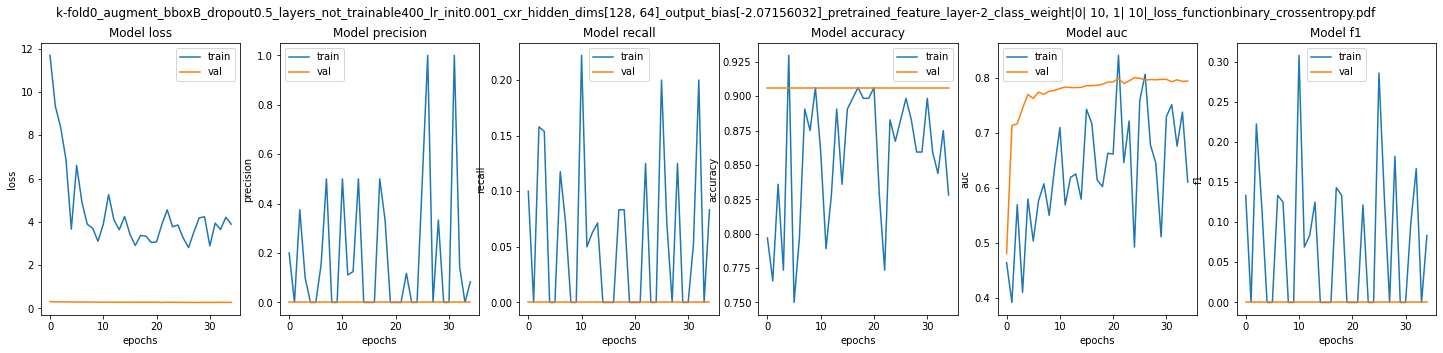

In [ ]:
history = cxr320.round_history
results = cxr320.data
for h in history:
    f1 = [calculate_f1(p,r) for p,r in zip(h['precision'],h['recall'])]
    val_f1 = [calculate_f1(p,r) for p,r in zip(h['val_precision'],h['val_recall'])]
    h['f1'] = f1
    h['val_f1'] = val_f1

params = ['k-fold','augment_bbox', 'dropout', 'layers_not_trainable', 'lr_init', 'cxr_hidden_dims',
       'output_bias', 'pretrained_feature_layer','class_weight', 'loss_function']
plot_history(results, history, params)

In [ ]:
TARGET_SIZE = 320
MODEL_TEACHER = ['gs://first_cxr/model/mimic_gen_aug_epoch5.h5'] # 320x320 input

# set 1
cxr_search_space = {
    "batch_size": BATCH_SIZE,
    "class_weight": [{0:10 , 1:10}],
    "dropout": [0.5],
    "epochs": [50],
    "lr_init": [0.001,0.003],
    "loss_function": ['binary_crossentropy'], 
    "model_type": ['cxr_model'],
    "tab_out_dim": [1],
    "cxr_hidden_dims": [[128,64]],
    "output_bias": [initial_bias], #[None, initial_bias],
    "layers_not_trainable": [355, 400], # max layers 428 for Po-Chi's base cxr model
    'pretrained_feature_layer': [-2,-4],
    "augment_bbox": ['B'], #[False]
    "model_teacher": MODEL_TEACHER,
    "k-fold":[0,1,2,3],
}

# set 2
cxr_search_space = {
    "batch_size": BATCH_SIZE,
    "class_weight": [{0:10 , 1:10}],
    "dropout": [0.5],
    "epochs": [50],
    "lr_init": [0.001,0.002,0.003],
    "loss_function": ['binary_crossentropy'], 
    "model_type": ['cxr_model'],
    "tab_out_dim": [1],
    "cxr_hidden_dims": [[128,64],[128,128,64]],
    "output_bias": [initial_bias], #[None, initial_bias],
    "layers_not_trainable": [400], # max layers 428 for Po-Chi's base cxr model
    'pretrained_feature_layer': [-2, -4],
    "augment_bbox": [False] , #['B']
    "model_teacher": MODEL_TEACHER,
    "k-fold":[0,1,2,3],
}

# https://towardsdatascience.com/smart-hyperparameter-optimization-of-any-deep-learning-model-using-tpu-and-talos-9eb48d09d637
with CustomObjectScope({'GlorotUniform': tf.keras.initializers.glorot_uniform()}):
    cxr320 = ta.Scan(x='x', y='y', x_val= 'xval',y_val= 'yval', # seems to be required input args but irrelevant for tune_coviv19_models i think
                        model=tune_covid19_models,
                        params=cxr_search_space,
                        experiment_name='tune_covid19_models')

In [ ]:
cxr320_search_report = ta.Reporting(cxr320).data
report_filename = 'cxr320_rough_search_report_nobbox.csv'
report_filename = 'cxr320_rough_search_report_bbox.csv'
report_filename = 'cxr320_focalsigmoidloss_report_bbox.csv'
report_filename = 'cxr320_focalsigmoidloss_report_bbox2.csv'
report_filename = 'cxr320_f1_loss_report_bbox.csv'
report_filename = 'cxr320_binary_crossentropy_report_bbox.csv'
report_filename = 'cxr320_4fold_report_bbox.csv'
report_filename = 'cxr320_4fold_report_bbox_7feb.csv'
report_filename = 'cxr320_4fold_report_bbox_8feb.csv'
report_filename = 'cxr320_4fold_report_nobbox_11feb.csv'
report_filename = 'cxr320_4fold_report_bbox_12feb.csv'

export_to_gcs(cxr320_search_report, report_filename, 'gs://new_cxr_30/models/cxr_models')
cxr320_search_report.to_csv(os.path.join('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models',report_filename))

round_history = cxr320.round_history
filename = 'cxrmodel320_rough_search_roundhistory_nobbox.json'
filename = 'cxrmodel320_rough_search_roundhistory_bbox.json'
filename = 'cxrmodel320_focalsigmoidloss_roundhistory_bbox.json'
filename = 'cxrmodel320_focalsigmoidloss_roundhistory_bbox2.json'
filename = 'cxrmodel320_f1_loss_roundhistory_bbox2.json'
filename = 'cxrmodel320_binary_crossentropy_roundhistory_bbox.json'
filename = 'cxrmodel320_4fold_roundhistory_bbox.json'
filename = 'cxrmodel320_4fold_roundhistory_bbox_7feb.json'
filename = 'cxrmodel320_4fold_roundhistory_bbox_8feb.json'
filename = 'cxrmodel320_4fold_roundhistory_nobbox_11feb.json'
filename = 'cxrmodel320_4fold_roundhistory_bbox_12feb.json'

with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models',filename), 'w') as fout:
    json.dump(round_history, fout)
with open(filename, 'w') as fout:
    json.dump(round_history, fout)
    export_to_gcs(fout, filename, 'gs://new_cxr_30/models/cxr_models')


In [ ]:
history = cxr320.round_history
results = cxr320.data
for h in history:
    f1 = [calculate_f1(p,r) for p,r in zip(h['precision'],h['recall'])]
    val_f1 = [calculate_f1(p,r) for p,r in zip(h['val_precision'],h['val_recall'])]
    h['f1'] = f1
    h['val_f1'] = val_f1

params = ['k-fold','augment_bbox', 'dropout', 'layers_not_trainable', 'lr_init', 'cxr_hidden_dims',
       'output_bias', 'pretrained_feature_layer','class_weight', 'loss_function']
plot_history(results, history, params)

In [ ]:
# cxr320_standard_report = ta.Reporting(cxr320_standard).data
# report_filename = 'cxr320_standard_search_report3.csv'
# export_to_gcs(cxr320_standard_report, report_filename, 'gs://new_cxr_30/models/cxr_models')
# cxr320_standard_report.to_csv(os.path.join('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models',report_filename))

In [ ]:
# averaging weights
# https://stackoverflow.com/questions/48212110/average-weights-in-keras-models

## Tuning CXR experiments with 224 pretrained model

In [ ]:
TARGET_SIZE = 224
# trained for pneumonia detection: https://github.com/brucechou1983/CheXNet-Keras#trained-model-weights
MODEL_TEACHER = ['gs://first_cxr/model/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'] # 224x224 input

def read_image_label_and_path(img_path):
    bits = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(bits, channels=1)
    image = tf.image.resize(image, [TARGET_SIZE, TARGET_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.strings.split(img_path, sep='/')[4]
    return image, label, img_path

# # Hyperparameter search space
# cxr_search_space = {
#     "batch_size": BATCH_SIZE,
#     "class_weight": CLASS_WEIGHT,
#     "dropout": DROPOUT,
#     "epochs": EPOCHS,
#     "lr_init": LR_INIT,
#     "model_type": ['cxr_model'],
#     "tab_out_dim": [1],
#     "cxr_hidden_dims": CXR_HIDDEN_DIMS,
#     "output_bias": BIAS,
#     "layers_not_trainable": LAYERS_NOT_TRAINABLE, # max layers 428 for Po-Chi's base cxr model
#     'pretrained_feature_layer': PRETRAINED_FEATURE_LAYER,
#     "augment_bbox": AUGMENT_BBOX,
#     "model_teacher": MODEL_TEACHER,
# }

cxr_search_space = {
    "batch_size": BATCH_SIZE,
    "class_weight": [{0:10 , 1:10}], # class weight doesn't really help
    "dropout": [0.5],
    "epochs": [40],
    "lr_init": [0.001, 0.003, 0.006], # learning reate 0.009 is too high
    "loss_function": ['binary_crossentropy'], # both pretty bad -- not learning at all
    "model_type": ['cxr_model'],
    "tab_out_dim": [1],
    "cxr_hidden_dims": [[128],[128,64],[128,128,64]],
    "output_bias": BIAS, #[None, initial_bias],
    "layers_not_trainable": [355,400], # max layers 428 for Po-Chi's base cxr model
    'pretrained_feature_layer': [-2,-4],
    "augment_bbox": ['B'],
    "model_teacher": MODEL_TEACHER,
    "k-fold":[1],
}
# most val F1, precision and recall are really low for these search params, seems to be doing worse than the 320 model


# https://towardsdatascience.com/smart-hyperparameter-optimization-of-any-deep-learning-model-using-tpu-and-talos-9eb48d09d637
with CustomObjectScope({'GlorotUniform': tf.keras.initializers.glorot_uniform()}):
    cxr224 = ta.Scan(x='x', y='y', x_val= 'xval',y_val= 'yval', # seems to be required input args but irrelevant for tune_coviv19_models i think
                        model=tune_covid19_models,
                        params=cxr_search_space,
                        experiment_name='tune_covid19_models')

In [ ]:
cxr224_search_report = ta.Reporting(cxr224).data
report_filename = 'cxr224_fine_search_report.csv'
report_filename = 'cxr224_binary_crossentropy_report_bbox.csv'
export_to_gcs(cxr224_search_report, report_filename, 'gs://new_cxr_30/models/cxr_models')
cxr320_search_report.to_csv(os.path.join('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models',report_filename))

round_history = cxr224.round_history

filename = 'cxrmodel224_fine_search_roundhistory.json'
filename = 'cxrmodel224_binary_crossentropy_roundhistory_bbox.json'

with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models',filename), 'w') as fout:
    json.dump(round_history, fout)
with open(filename, 'w') as fout:
    json.dump(round_history, fout)
    export_to_gcs(fout, filename, 'gs://new_cxr_30/models/cxr_models')

## Train late fusion model

In [ ]:
# offline approach:
# base model on image, get 14 cxr finding prediciton, concat with structured, then downstream predict mortality
# or best CXR model output with rest of structured data
# can try tabular deep learning model and all the different models that Wesley tried

In [ ]:
# Po-Chih is doing separately

## Train intermediate fusion model

In [ ]:
# pretrained CXR model input image width/height
TARGET_SIZE = 320
MODEL_TEACHER = ['gs://first_cxr/model/mimic_gen_aug_epoch5.h5'] # 320x320 input

cxr_search_space = {
    "batch_size": BATCH_SIZE,
    "class_weight": [{0:10 , 1:10}], # tunable
    "dropout": [0.5], # tunable
    "epochs": [50], # maximum number because there is early stopping
    "lr_init": [0.001,0.002,0.003], # tunable
    "loss_function": ['binary_crossentropy'], 
    "model_type": ['fused_model'],
    "tab_out_dim": [32, 64], # this may need to be changed to larger for fused model
    "cxr_hidden_dims": [[128,64], [128, 32], [128,128,64]],
    "output_bias": [initial_bias], #[None, initial_bias],
    "layers_not_trainable": [355, 400], # max layers 428 for Po-Chi's base cxr model
    'pretrained_feature_layer': [-2, -4],
    "augment_bbox": ['B'],
    "model_teacher": MODEL_TEACHER,
    "k-fold":[0,1,2,3],
}

# https://towardsdatascience.com/smart-hyperparameter-optimization-of-any-deep-learning-model-using-tpu-and-talos-9eb48d09d637
with CustomObjectScope({'GlorotUniform': tf.keras.initializers.glorot_uniform()}):
    cxr320 = ta.Scan(x='x', y='y', x_val= 'xval',y_val= 'yval', # seems to be required input args but irrelevant for tune_coviv19_models i think
                        model=tune_covid19_models,
                        params=cxr_search_space,
                        experiment_name='tune_covid19_models')

In [ ]:
# plot and save
history = cxr320.round_history
results = cxr320.data
for h in history:
    f1 = [calculate_f1(p,r) for p,r in zip(h['precision'],h['recall'])]
    val_f1 = [calculate_f1(p,r) for p,r in zip(h['val_precision'],h['val_recall'])]
    h['f1'] = f1
    h['val_f1'] = val_f1

params = ['k-fold','augment_bbox', 'dropout', 'layers_not_trainable', 'lr_init', 'cxr_hidden_dims',
       'output_bias', 'pretrained_feature_layer','class_weight', 'loss_function']
plot_history(results, history, params)

In [ ]:
cxr320_search_report = ta.Reporting(cxr320).data
report_filename = 'change this.csv'

export_to_gcs(cxr320_search_report, report_filename, 'gs://new_cxr_30/models/cxr_models')
cxr320_search_report.to_csv(os.path.join('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models',report_filename))

round_history = cxr320.round_history
filename = 'change this.json'

with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models',filename), 'w') as fout:
    json.dump(round_history, fout)
with open(filename, 'w') as fout:
    json.dump(round_history, fout)
    export_to_gcs(fout, filename, 'gs://new_cxr_30/models/cxr_models')


## Train structured model/encoder

### Structured only

In [ ]:
# Hyperparameter search space - some search spaces are not need for some models
tab_search_space = {
    "batch_size": BATCH_SIZE,
    "class_weight": CLASS_WEIGHT,
    "dropout": DROPOUT,
    "epochs": EPOCHS,
    "lr_init": LR_INIT,
    "model_type": ['tab_model'],
    "tab_out_dim": [structured_feature_size],
    "cxr_out_dim": [structured_feature_size],
    "layers_not_trainable": [355], # max layers 428 for Po-Chi's base cxr model
    "augment_bbox": [False],
    "model_teacher": [''],
}
# https://towardsdatascience.com/smart-hyperparameter-optimization-of-any-deep-learning-model-using-tpu-and-talos-9eb48d09d637
with CustomObjectScope({'GlorotUniform': tf.keras.initializers.glorot_uniform()}):
    tab_results = ta.Scan(x='x', y='y', x_val= 'xval',y_val= 'yval', # seems to be required input args but irrelevant for tune_coviv19_models i think
                        model=tune_covid19_models,
                        params=tab_search_space,
                        experiment_name='tune_covid19_models')

In [ ]:
tab_report = ta.Reporting(tab_results).data

In [ ]:
tab_report.head()

In [ ]:
val_precision = tab_report.val_precision.tolist()
val_loss = tab_report.val_loss.tolist()
val_recall = tab_report.val_recall.tolist() 
val_accuracy = tab_report.val_binary_accuracy.tolist() 
lr = tab_report.lr_init.tolist() # no real trend but top performing around 0.009 initial learning rate (already using kera's learning rate scheduler)
epochs = tab_report.round_epochs.tolist() # top performers converge before epoch 5
bz = tab_report.batch_size.tolist() # larger didn't help
cw = [x[0] for x in tab_report.class_weight.tolist()] # recall higher if max weight for minority class, precision the reverse - expected behavior
drop = tab_report.dropout.tolist() 

# x, y = zip(*sorted(zip(lr, loss)))
x = drop
y = val_precision


plt.plot(x, y, 'o', color='black');

In [ ]:
best_accuracy = tab_report['val_binary_accuracy'].astype('float').argmax()
print(best_accuracy)
tab_report.loc[best_accuracy,:]

In [ ]:
best_precision = tab_report['val_precision'].astype('float').argmax()
print(best_precision)
tab_report.loc[best_precision,:]

In [ ]:
best_recall = tab_report['val_recall'].astype('float').argmax()
print(best_recall)
tab_report.loc[best_recall,:]

In [ ]:
# Took quite ~4 hours on cpu...
# Deep learning models likely note best choice to learn on a small dataset like this 
# as compared to RF, XGB, etc that Wesley did -- as expected
# But weights combine better in fusion case if the structured data is first passed through some deep learning layers

# filename = 'structured_tuning_report.csv'
# exportdir = 'gs://new_cxr_30/models/structured/'
# export_to_gcs(tab_report, filename, exportdir)

In [ ]:
# model_precision = get_best_model(tab_results, 'val_precision')
# model_recall = get_best_model(tab_results, 'val_precision')
# model_accuracy = get_best_model(tab_results, 'val_binary_accuracy')

# exportdir = 'gs://new_cxr_30/models/structured/talos_tuned_models/'
# date = '2020_12_25'
# export_to_gcs(model_precision, 'structured_best_precision_'+date+'.h5', exportdir)
# export_to_gcs(model_recall, 'structured_best_recall_'+date+'.h5', exportdir)
# export_to_gcs(model_accuracy, 'structured_best_accuracy_'+date+'.h5', exportdir)

### CXR only

In [ ]:
# Hyperparameter search space
cxr_search_space = {
    "batch_size": BATCH_SIZE,
    "class_weight": CLASS_WEIGHT,
    "dropout": DROPOUT,
    "epochs": EPOCHS,
    "lr_init": LR_INIT,
    "model_type": ['cxr_model'],
    "tab_out_dim": [structured_feature_size],
    "cxr_out_dim": [structured_feature_size],
    "layers_not_trainable": [355, 400, 420], # max layers 428 for Po-Chi's base cxr model
    "augment_bbox": [False],#AUGMENT_BBOX,
    "model_teacher": MODEL_TEACHER,
}
# https://towardsdatascience.com/smart-hyperparameter-optimization-of-any-deep-learning-model-using-tpu-and-talos-9eb48d09d637
with CustomObjectScope({'GlorotUniform': tf.keras.initializers.glorot_uniform()}):
    cxr_results = ta.Scan(x='x', y='y', x_val= 'xval',y_val= 'yval', # seems to be required input args but irrelevant for tune_coviv19_models i think
                        model=tune_covid19_models,
                        params=cxr_search_space,
                        experiment_name='tune_covid19_models')

# cxr_results = tune_multiprocess(cxr_search_space, 'tune_covid19_models')

In [ ]:
cxr_results.data

### Intermediate fusion

In [ ]:
# Hyperparameter search space
fused_search_space = {
    "batch_size": BATCH_SIZE,
    "class_weight": CLASS_WEIGHT,
    "dropout": DROPOUT,
    "epochs": EPOCHS,
    "lr_init": LR_INIT,
    "model_type": ['fused_model'],
    "tab_out_dim": [64], #[structured_feature_size, 64, 128],
    "cxr_out_dim": [64], #[structured_feature_size, 64, 128],
    "layers_not_trainable": [400],#[355, 400, 420], # max layers 428 for Po-Chi's base cxr model
    "augment_bbox": [False],#AUGMENT_BBOX, #eagarly execution still doesn't work on cloud tpu...
    "model_teacher": MODEL_TEACHER,
}
# https://towardsdatascience.com/smart-hyperparameter-optimization-of-any-deep-learning-model-using-tpu-and-talos-9eb48d09d637
with CustomObjectScope({'GlorotUniform': tf.keras.initializers.glorot_uniform()}):
    fused_results = ta.Scan(x='x', y='y', x_val= 'xval',y_val= 'yval', # seems to be required input args but irrelevant for tune_coviv19_models i think
                        model=tune_covid19_models,
                        params=fused_search_space,
                        experiment_name='tune_covid19_fused_models')

In [ ]:
fused_report = ta.Reporting(fused_results).data
fused_report.head()

In [ ]:
fused_report[fused_report.val_precision > 0.5]

In [ ]:
fused_report[fused_report.val_recall > 0.3]

# ReTrain CXR model on whole dataset with best params

In [ ]:
def train(config, valid = True):
    tf.keras.backend.clear_session()
    
    print(config)
    # args
    args = type('', (), {})()
    # Hyperparameters that can be tuned
    args.model_type = config['model_type'] #'tab_model','cxr_model','model_fused'
    args.tab_out_dim = config['tab_out_dim']
    #args.cxr_out_dim = config['cxr_out_dim'] # last hidden dim would be the cxr_out_dim so fewer search params
    args.augment_bbox = config['augment_bbox']
    args.model_teacher = config['model_teacher']
    args.lr_init = config['lr_init']
    args.epochs = config["epochs"]
    args.dropout = config['dropout']
    args.batch_size = config['batch_size']
    args.loss_function = config['loss_function']
    args.class_weight = config['class_weight']
    args.layers_not_trainable = config['layers_not_trainable']
    args.pretrained_feature_layer = config['pretrained_feature_layer']
    args.cxr_hidden_dims = config['cxr_hidden_dims']
    args.output_bias = config['output_bias']
    args.steps_per_epoch = int(len(training_filenames)) // args.batch_size
    args.val_steps = int(len(validation_filenames)) // args.batch_size
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(args.batch_size, args.steps_per_epoch, args.val_steps))
    args.fold = config['k-fold']

    # input and output parameters
    args.train_table_path = 'gs://new_cxr_30/split/train_structured.csv'
    args.valid_table_path = 'gs://new_cxr_30/split/valtest_structured.csv'
    args.test_table_path = 'gs://new_cxr_30/split/test_structured.csv'
    args.combined_table_path = 'gs://new_cxr_30/split/combined_structured.csv'
    args.xfeatures = XFEATURES
    args.image_path_train = 'gs://new_cxr_30/classified/*/train_*.jpg'
    args.image_path_test = 'gs://new_cxr_30/classified/*/test_*.jpg' 
    #args.resize = TARGET_SIZE
    args.num_workers = 16 # can reduce to optimize memory
    args.rseed = SEED
    args.output_dir = 'gs://new_cxr_30/models/'

    # Create saving dir, all useful variables
    output_model_path = os.path.join(args.output_dir, args.model_type)
    if not os.path.exists(output_model_path): 
        os.makedirs(output_model_path)
    
    # Option for k-fold splits for train/val, k=4
    if args.fold == 'all':
        dftrain = pd.read_csv(args.combined_table_path)
        valid = False
    else:
        dfall = pd.read_csv(args.combined_table_path)
        dfvalid = dfall[dfall.fold==args.fold].copy()
        dftrain = dfall[~dfall.index.isin(dfvalid.index.tolist())].copy()

    # Need to load datasets before initializing tpu or will have address error
    # problem:https://github.com/tensorflow/tensorflow/issues/43037
    # solution: https://colab.research.google.com/drive/1kpCDInclZHLOvb-9MOgQHUfJfsg8748Z#scrollTo=ZbJDZ6chSWOb

    # Compile model
    with strategy.scope():
        # Load data to iterator
        # argumetns: get_augmented_batched_dataset_(structured_path, xfeatures, model_type, batch_size, rseed, train=True)
        train_dl = get_augmented_batched_dataset_(dftrain, args.xfeatures
                                , args.model_type, args.batch_size, args.augment_bbox, args.rseed, train=True)
        if valid:
            valid_dl = get_augmented_batched_dataset_(dfvalid, args.xfeatures
                                    , args.model_type, args.batch_size, False, args.rseed, train=False)
        #test_dl = get_augmented_batched_dataset_(args.test_table_path, args.xfeatures
                                #, args.model_type, args.batch_size, False, args.rseed, train=False)
        
        # # Logs in keras -- no idea where things are being saved
        # checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(output_model_path,'model-{epoch:03d}.h5')
        #                                                 , verbose=1, monitor='val_auc'
        #                                                 ,save_best_only=True, mode='max')  
        # early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode = 'max'
        #                                                 , verbose = 1, restore_best_weights=True)
        
        # Tune learning rate
        initial_learning_rate = config['lr_init']
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate
                        , decay_steps=100000, decay_rate=0.96, staircase=True)  
        
        # Getting error with serializing subclassed models...which cannot be done! so changed models to functional
        # https://stackoverflow.com/questions/51806852/cant-save-custom-subclassed-model
        # Pick the model to fit
        if args.model_type == 'tab_model':
            #input: input_dim, drop+out
            model = TabularModel_functional(len(args.xfeatures), args.dropout)
        elif args.model_type == 'cxr_model':
            base = load_base_model(args.model_teacher) # load base model from gb to local runtime
            #input: drop_out, layers_not_trainable
            model = CXRModel_functional(base, args.dropout, args.layers_not_trainable
                                        , pretrained_feature_layer=args.pretrained_feature_layer
                                        , hidden_dims = args.cxr_hidden_dims
                                        , output_bias = args.output_bias
                                        )
        elif args.model_type == 'fused_model':
            base = load_base_model(args.model_teacher) # load base model from gb to local runtime
            #input: tab_input_dim, drop_out, layers_not_trainable, tab_out_dim, cxr_out_dim
            model = Combined_Model_functional(base, len(args.xfeatures), args.dropout, args.layers_not_trainable
                                        ,args.pretrained_feature_layer, args.cxr_hidden_dims
                                        , args.tab_out_dim 
                                        #, args.cxr_out_dim
                                        , output_bias = args.output_bias
                                        )
        else:
            print('Model type does not exist')
        METRICS = [
                tf.keras.metrics.TruePositives(name='tp'),
                tf.keras.metrics.FalsePositives(name='fp'),
                tf.keras.metrics.TrueNegatives(name='tn'),
                tf.keras.metrics.FalseNegatives(name='fn'), 
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                tf.keras.metrics.AUC(name='auc'),
                #f1,
                #tfa.metrics.F1Score(2, name='f1_score') # gives an error
                ]
        
        # likely do better for imbalanced data: https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy
        if args.loss_function == 'sigmoid_focal_crossentropy':
            loss = tfa.losses.SigmoidFocalCrossEntropy()
        elif args.loss_function == 'f1_loss':  
            loss = f1_loss
        elif args.loss_function == 'macro_double_soft_f1':
            loss = macro_double_soft_f1
        else:
            loss = args.loss_function
        
        model.compile(
            #optimizer='adam',
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=loss,
            metrics=METRICS,
        )

    # Fit the model in tf.keras...
    if valid:
        history = model.fit(train_dl,
                            steps_per_epoch = args.steps_per_epoch,
                            epochs = args.epochs, 
                            validation_data = valid_dl,
                            shuffle = True,
                            class_weight = args.class_weight, 
                            #callbacks=[checkpoint, early_stopping_cb]
                            )
    else:
        history = model.fit(train_dl,
                            steps_per_epoch = args.steps_per_epoch,
                            epochs = args.epochs, 
                            shuffle = True,
                            class_weight = args.class_weight, 
                            #callbacks=[checkpoint, early_stopping_cb]
                            )
    
    # Visualize
    
    # might not need this in tensorflow 2.x
    # if USE_TPU:
    #     return history, model #.sync_to_cpu() 
    # else:
    return history, model

## Train 4 separate models on the different dataset splits on the final hyperparameters

To generate likelihood numbers for different splits for the late fusion model.

If trained on all data then the fusion model will likely expect a better than would be in real life likelihood number from the CXR model.

In [ ]:
TARGET_SIZE = 320
MODEL_TEACHER = 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5' # 320x320 input
folds = [0,1,2,3]

config = {
        "batch_size": 16,
        "class_weight": {0:10 , 1:10},
        "dropout": 0.5,
        "epochs": 19,
        "lr_init": 0.002,
        "loss_function": 'binary_crossentropy', 
        "model_type": 'cxr_model',
        "tab_out_dim": 1,
        "cxr_hidden_dims": [128,64],
        "output_bias": initial_bias, #[None, initial_bias],
        "layers_not_trainable": 400, # max layers 428 for Po-Chi's base cxr model
        'pretrained_feature_layer': -2,
        "augment_bbox": 'B', #[False]
        "model_teacher": MODEL_TEACHER,
        "k-fold":None,
    }
    
# final params on different splits
histories = []
models = []
for fold in folds:
    fold_config = config.copy()
    fold_config['k-fold'] = fold
    fold_history, fold_model = train(fold_config)
    histories.append(fold_history)
    models.append(fold_model)

In [ ]:
# four fold training results
model_path = '/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models/final'
if not os.path.isdir(model_path):
    os.makedirs(model_path)

params = ['k-fold','augment_bbox', 'dropout', 'layers_not_trainable', 'lr_init', 'cxr_hidden_dims',
       'output_bias', 'pretrained_feature_layer','class_weight', 'loss_function']

for fold, history, model in zip(folds, histories, models):
    fold_config = config.copy()
    fold_config['k-fold'] = fold
    fname = []
    for p in params:
        v = fold_config[p]
        if type(v)==float: v=round(v,4)
        fname.append(p+str(v))
    fname = '_'.join(fname)
    fname = fname.replace(':','|').replace('{','|').replace('}','|')

    f1 = [calculate_f1(p,r) for p,r in zip(history.history['precision'],history.history['recall'])]
    val_f1 = [calculate_f1(p,r) for p,r in zip(history.history['val_precision'],history.history['val_recall'])]
    history.history['f1'] = f1
    history.history['val_f1'] = val_f1

    metrics = ["loss","precision", "recall", "accuracy", "auc","f1"]
    fig, ax = plt.subplots(1, len(metrics), figsize=(25, 5))
    ax = ax.ravel()

    for i, met in enumerate(metrics):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history["val_" + met])
        ax[i].set_title("Model {}".format(met))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(met)
        ax[i].legend(["train"])


    plt.savefig(os.path.join(model_path, fname+'.pdf'))
    model.save(os.path.join(model_path,fname+'.h5'))
    with open(os.path.join(model_path,fname+'.json'), 'w') as outfile:
        json.dump(history.history, outfile)

In [ ]:
combined_table_path = 'gs://new_cxr_30/split/combined_structured.csv'
dfall = pd.read_csv(combined_table_path)

valresults = {'fold':[],'predicted_probability':[],'y_encoded':[],'path':[]}
for fold in folds:
    dfvalid = dfall[dfall.fold==fold].copy()
    valid_dl = get_augmented_batched_dataset_(dfvalid, XFEATURES, '', len(dfvalid), False, SEED, train=False)    
    for structured, images, labels, labels_encoded, img_paths, bbox_coords in valid_dl:
        print(images.shape)
        ys = labels_encoded.numpy().tolist()
        paths = img_paths.numpy().tolist()
        y_prob = models[fold].predict(images)
        y_prob = [x[0] for x in y_prob]
        y_classes = [1 if x > 0.5 else 0 for x in y_prob]
        for prob, c, y, path  in zip(y_prob, y_classes, ys, paths):
            valresults['fold'].append(fold)
            valresults['predicted_probability'].append(prob)
            valresults['y_encoded'].append(y)
            valresults['path'].append(path)


In [ ]:
dfresults = pd.DataFrame(valresults).copy()   
print(dfresults.shape)
dfresults['path'] = [x.decode("utf-8") for x in dfresults['path']]
dfresults.head()


In [ ]:
print(dfall.shape)
keep = ['path','predicted_probability']
dfstructure_cxr = dfall.merge(dfresults[keep],how = 'left', left_on='path',right_on='path')
print(dfstructure_cxr.shape)
dfstructure_cxr.head()

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models/final'
fname = '4fold_models_predictions.csv'
dfstructure_cxr.to_csv(os.path.join(model_path,fname),encoding='utf-8',index=False)
export_to_gcs(dfstructure_cxr, fname, 'gs://new_cxr_30/predictions/cxr_model')

## To train the final CXR model end to end for prediction on test set

In [ ]:
TARGET_SIZE = 320
MODEL_TEACHER = 'gs://first_cxr/model/mimic_gen_aug_epoch5.h5' # 320x320 input
fold = 'all'

# final params on different splits
cxr_config = {
    "batch_size": 16,
    "class_weight": {0:10 , 1:10},
    "dropout": 0.5,
    "epochs": 19,
    "lr_init": 0.002,
    "loss_function": 'binary_crossentropy', 
    "model_type": 'cxr_model',
    "tab_out_dim": 1,
    "cxr_hidden_dims": [128,64],
    "output_bias": initial_bias, #[None, initial_bias],
    "layers_not_trainable": 400, # max layers 428 for Po-Chi's base cxr model
    'pretrained_feature_layer': -2,
    "augment_bbox": 'B', #[False]
    "model_teacher": MODEL_TEACHER,
    "k-fold":fold,
}

history, model = train(cxr_config, valid = False)

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models/final'
if not os.path.isdir(model_path):
    os.makedirs(model_path)

params = ['k-fold','augment_bbox', 'dropout', 'layers_not_trainable', 'lr_init', 'cxr_hidden_dims',
       'output_bias', 'pretrained_feature_layer','class_weight', 'loss_function']

fname = []
for p in params:
    v = cxr_config[p]
    if type(v)==float: v=round(v,4)
    fname.append(p+str(v))
fname = '_'.join(fname)
fname = fname.replace(':','|').replace('{','|').replace('}','|')
print(fname)

model.save(os.path.join(model_path,fname + '.h5'))
export_to_gcs(model, fname + '.h5', 'gs://new_cxr_30/models/cxr_models')

In [ ]:
with open(os.path.join(model_path,fname+'.json'), 'w') as outfile:
    json.dump(history.history, outfile)

In [ ]:
# final training curve
f1 = [calculate_f1(p,r) for p,r in zip(history.history['precision'],history.history['recall'])]
history.history['f1'] = f1

metrics = ["loss","precision", "recall", "accuracy", "auc","f1"]
fig, ax = plt.subplots(1, len(metrics), figsize=(25, 5))
ax = ax.ravel()

for i, met in enumerate(metrics):
    ax[i].plot(history.history[met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train"])
plt.savefig(os.path.join(model_path, fname+'.pdf'))

In [ ]:
combined_table_path = 'gs://new_cxr_30/split/combined_structured.csv'
dfall = pd.read_csv(combined_table_path)

data_l = get_augmented_batched_dataset_(dfall, XFEATURES, '', len(dfall), False, SEED, train=False)
results = {'predicted_probability':[],'y':[],'path':[]}
for structured, images, labels, labels_encoded, img_paths, bbox_coords in data_l:
    print(images.shape)
    ys = labels_encoded.numpy().tolist()
    paths = img_paths.numpy().tolist()
    y_prob = model.predict(images)
    y_prob = [x[0] for x in y_prob]
    for p, y, path in zip(y_prob, ys, paths):
        results['predicted_probability'].append(p)
        results['y'].append(y)
        results['path'].append(path)
results = pd.DataFrame(results).copy()
results['path'] = [x.decode("utf-8") for x in results['path']]

print(results.shape)
results.head()

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models/final'
fname = 'end2end_final_model_predictions.csv'
results.to_csv(os.path.join(model_path,fname),encoding='utf-8',index=False)
export_to_gcs(results, fname, 'gs://new_cxr_30/predictions/cxr_model')

# Visualize Results

In [ ]:
history = cxr320.round_history
results = cxr320.data
for h in history:
    f1 = [calculate_f1(p,r) for p,r in zip(h['precision'],h['recall'])]
    val_f1 = [calculate_f1(p,r) for p,r in zip(h['val_precision'],h['val_recall'])]
    h['f1'] = f1
    h['val_f1'] = val_f1

params = ['k-fold','augment_bbox', 'dropout', 'layers_not_trainable', 'lr_init', 'cxr_hidden_dims',
       'output_bias', 'pretrained_feature_layer','class_weight', 'loss_function']
plot_history(results, history, params)

In [ ]:
metrics = ["loss","precision", "recall", "accuracy", "auc","f1"]

params = ['k-fold','lr_init', 'cxr_hidden_dims']

history = cxr320.round_history
results = cxr320.data
for h in history:
    f1 = [calculate_f1(p,r) for p,r in zip(h['precision'],h['recall'])]
    val_f1 = [calculate_f1(p,r) for p,r in zip(h['val_precision'],h['val_recall'])]
    h['f1'] = f1
    h['val_f1'] = val_f1

frames = []
for i in results.index:
    df = pd.DataFrame(history[i])
    rounds = list(range(0,len(df)))
    for p in params:
        v = results.loc[i,p]
        # print(p, type(v))
        if type(v)==list: 
            v = str(v)
        df[p] = v
    df['experiment'] = i
    df['round_epoch'] = rounds
    df['differentiating_params'] = str(results.loc[i,'lr_init'])+'|' + str(results.loc[i,'cxr_hidden_dims'])
    frames.append(df)
dfrh = pd.concat(frames,ignore_index=True)
print(dfrh.shape)
dfrh.head()

In [ ]:
dfmax_auc = dfrh.groupby(['k-fold','differentiating_params','experiment'], as_index=False)['val_auc'].max()
dfmax_auc['index'] = [dfrh[(dfrh['val_auc']== v)&(dfrh['experiment']==e)].index.tolist()[0] for v, e in zip(dfmax_auc['val_auc'],dfmax_auc['experiment'])]
addcols = ['val_f1','val_precision','val_recall','round_epoch']
for col in addcols:
    dfmax_auc[col] = [dfrh.loc[idx,col] for idx in dfmax_auc['index']]
dfmax_auc.sort_values(by=['differentiating_params','k-fold','val_auc'],ascending=[True,True,False],inplace=True)
dfmax_auc

In [ ]:
dfmax_f1 = dfrh.groupby(['k-fold','differentiating_params','experiment'], as_index=False)['val_f1'].max()
dfmax_f1['index'] = [dfrh[(dfrh['val_f1']== v)&(dfrh['experiment']==e)].index.tolist()[0] for v, e in zip(dfmax_f1['val_f1'],dfmax_f1['experiment'])]
addcols = ['val_auc','val_precision','val_recall','round_epoch']
for col in addcols:
    dfmax_f1[col] = [dfrh.loc[idx,col] for idx in dfmax_f1['index']]
dfmax_f1.sort_values(by=['differentiating_params','k-fold','val_f1'],ascending=[True,True,False],inplace=True)
dfmax_f1

In [ ]:
dfmax_f1_averaged = dfmax_f1.groupby('differentiating_params').agg({'val_f1':'mean', 
                         'val_auc':'mean', 
                         'val_precision':'mean', 
                         'val_recall': 'mean'}).reset_index()

dfmax_f1_averaged.sort_values(by=['val_f1','val_auc','val_precision','val_recall'],ascending=[False,False,False,False],inplace=True)

dfmax_f1_averaged

# 0.002|[128, 64] seems to have the most steady performance across all split and all metrics on val set

# So how long shoudl we train for? Need to look at the learning curves for the experiments ran with this param

In [ ]:
exp = dfmax_f1[dfmax_f1.differentiating_params=='0.002|[128, 64]'].experiment.tolist()
print(exp)

selected_results = results[results.index.isin(exp)].copy()
params = ['k-fold','augment_bbox', 'dropout', 'layers_not_trainable', 'lr_init', 'cxr_hidden_dims',
       'output_bias', 'pretrained_feature_layer','class_weight', 'loss_function']

plot_history(selected_results, history, params)


In [ ]:
show = ['k-fold','val_f1','val_auc','val_precision','val_recall','round_epoch']
dfrh[(dfrh.experiment.isin(exp)&(dfrh.round_epoch.isin([15,16,17,18,19,20,21,22])))][show]

# 19 epochs looks best on average across the 4 splits

In [ ]:
history = cxr320.round_history
results = cxr320.data
for h in history:
    f1 = [calculate_f1(p,r) for p,r in zip(h['precision'],h['recall'])]
    val_f1 = [calculate_f1(p,r) for p,r in zip(h['val_precision'],h['val_recall'])]
    h['f1'] = f1
    h['val_f1'] = val_f1

params = ['k-fold','augment_bbox', 'dropout', 'layers_not_trainable', 'lr_init', 'cxr_hidden_dims',
       'output_bias', 'pretrained_feature_layer','class_weight', 'loss_function']
plot_history(results, history, params)

In [ ]:
# Opening JSON file with round history
f = open('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models/cxrmodel320_rough_search_roundhistory_nobbox.json',) 
# returns JSON object as  
# a dictionary 
history = json.load(f) 

# Read in results file with params per search experiment
results = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models/cxr320_rough_search_report_nobbox.csv')
print(results.shape)
results.head()

In [ ]:
# printed results
dfres = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models/cxr320_4fold_bboxes_search_report.csv')
dfres['f1'] = [calculate_f1(precision,recall) for precision,recall in zip(dfres['precision'],dfres['recall'])]
dfres['val_f1'] = [calculate_f1(precision,recall) for precision,recall in zip(dfres['val_precision'],dfres['val_recall'])]
dfres.head()

params = ['k-fold','augment_bbox', 'dropout', 'layers_not_trainable', 'lr_init', 'cxr_hidden_dims',
       'output_bias', 'pretrained_feature_layer','class_weight']
keep = ['experiment'] + params
dfres.columns = [x.strip() for x in dfres.columns.tolist()]
results = dfres[keep].drop_duplicates().reset_index(drop=True).copy()
print(results.shape)

history = []
metrics = ["loss","precision", "recall", "accuracy", "auc","f1"]
for i in results.index:
    exp = results.loc[i,'experiment']
    df = dfres[dfres.experiment == exp].copy()
    his = {}
    for m in metrics:
        his[m] = df[m].tolist()
        his['val_'+m] = df['val_' + m].tolist()
    history.append(his)

# history[0]

plot_history(results, history, params)

In [ ]:
report_filename = 'cxr320_4fold_report_bbox.csv'

export_to_gcs(results, report_filename, 'gs://new_cxr_30/models/cxr_models')
results.to_csv(os.path.join('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models',report_filename))

filename = 'cxrmodel320_4fold_roundhistory_bbox.json'
with open(os.path.join('/content/drive/MyDrive/Colab Notebooks/MIT_COVID19/models',filename), 'w') as fout:
    json.dump(history, fout)
with open(filename, 'w') as fout:
    json.dump(history, fout)
    export_to_gcs(fout, filename, 'gs://new_cxr_30/models/cxr_models')

In [ ]:
history = cxr224.round_history
results = cxr224.data
for h in history:
    f1 = [calculate_f1(p,r) for p,r in zip(h['precision'],h['recall'])]
    val_f1 = [calculate_f1(p,r) for p,r in zip(h['val_precision'],h['val_recall'])]
    h['f1'] = f1
    h['val_f1'] = val_f1

params = ['augment_bbox', 'dropout', 'layers_not_trainable', 'lr_init', 'cxr_hidden_dims',
       'output_bias', 'pretrained_feature_layer','class_weight', 'loss_function']
plot_history(results, history, params)

Comments: models aren't really learning yet -- need to tune

In [ ]:
params = ['augment_bbox', 'dropout', 'layers_not_trainable', 'lr_init', 
       'output_bias', 'pretrained_feature_layer','class_weight']
plot_history(results, history, params)

In [ ]:
idx=0
print(cxr320.data.loc[idx,:])
print(cxr320.data.columns)
visualize(cxr320.round_history[idx])
# cxr320.round_history[0]

In [ ]:
idx=1
print(cxr320.data.loc[idx,:])
visualize(cxr320.round_history[idx])

In [ ]:
idx=2
print(cxr320.data.loc[idx,:])
visualize(cxr320.round_history[idx])

In [ ]:
idx=3
print(cxr320.data.loc[idx,:])
visualize(cxr320.round_history[idx])

In [ ]:
# visualize(tab_history)

In [ ]:
# visualize(cxr_history) 

In [ ]:
# visualize(fused_history)

## Compare models with Bbox augmentation

In [ ]:
# seems to be learning better though not optimal and still need to tune

# the model seems to do the best on valid set in the first 1-2 epochs 
# then drops very sharply suddenly 
# then appears to quickly overfit on training data
# This may suggest that the original base CXR model is better trained to recognize key CXR image findings (14 chexpert findings)
# And that features learned for the 14 findings are good predictors of the patient mortality outcome even in this different Madrid dataset
# Tuning those weights on the small madrid dataset does not seem to be helping to performance (though we still haven't tuned properly)
# This also suggest that maybe we should try another late fusion approach where features are structured data + 14 predicted output from the base CXR model without transfer learning

# visualize(cxr_bbox_history)

In [ ]:
# visualize(fused_bbox_history)

## scratch

In [ ]:
# test_table_path = 'gs://new_cxr_30/split/test_structured.csv'

In [ ]:
# def model_prediction(model, test_ds):
# for image, label in test_ds.take(1):
#     plt.imshow(image[0] / 255.0)
#     plt.title(CLASSES[label[0].numpy()])

#     prediction = model.predict(test_ds.take(1))[0]
#     scores = [1 - prediction, prediction]

#     for score, name in zip(scores, CLASSES):
#         print("This image is %.2f percent %s" % ((100 * score), name))

In [ ]:
# tab_test_dl = get_augmented_batched_dataset_(test_table_path, xfeatures
#                             , 'tab_model', BATCH_SIZE, SEED, train=False)

In [ ]:
# tab_model.evaluate(test_ds, return_dict=True)

In [ ]:
# model_prediction(tab_model, tab_test_ds)